In [1]:
import torch
import json
import tqdm
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set_style("whitegrid")

num_classes = 1000

In [5]:
def evaluate_for_K(
    train_stats,
    val_stats,
    
):  
    stats = {}
    for surrogate_metric in train_stats.keys():
        best_config_id = train_stats[surrogate_metric][-1].argmax(dim=-1)
        for val_metric in val_stats.keys():
            best_val_score = val_stats[val_metric][-1, torch.arange(num_classes), best_config_id]
            stats[surrogate_metric, val_metric] = best_val_score
    return stats

K = list(range(25))

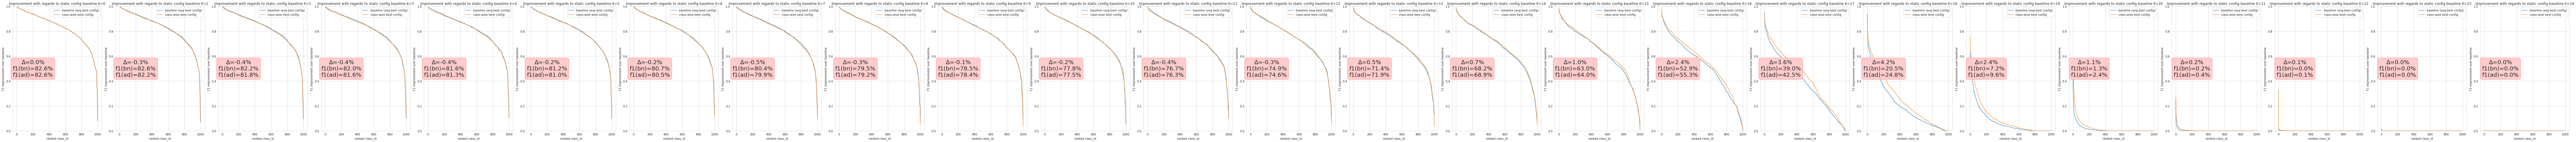

In [11]:

plt.figure(figsize=[5*len(K), 7])
baselines_f1 = {}
for i, k in enumerate(K, start=1):
    plt.subplot(1, len(K), i)
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    val_stats = torch.load(f"notebook-cache/swin/val_stats_k{k:02d}.pth")
    
    # Select just a single static config with the highest F1 over the training data
    train_mean_f1 = train_stats["f1"][-1].mean(dim=0)
    baseline_config = train_mean_f1.argmax()
    baseline_f1 = val_stats["f1"][-1, :, baseline_config]
    best_f1_per_class = evaluate_for_K(train_stats, val_stats)["f1", "f1"]
    deltas = best_f1_per_class-baseline_f1
    sorted_baseline_f1, sort_idxs = torch.sort(baseline_f1, descending=True)
    sorted_best_f1, _ = torch.sort(best_f1_per_class, descending=True)
    baselines_f1[k] = baseline_f1.mean().item()
    
    
    plt.title(f"Improvement with regards to static config baseline K={k}")
    plt.xlabel("ranked class_id")
    plt.ylabel("F1 improvement over baseline")
    plt.plot(range(1000), sorted_baseline_f1, alpha=0.8, label="baseline (avg best config)")
    # plt.plot(range(1000), best_f1_per_class[sort_idxs].numpy(), alpha=0.8, label="class-wise best config")
    plt.plot(range(1000), sorted_best_f1, alpha=0.8, label="class-wise best config")
    plt.ylim([0.0, 1.0])
    box_text = f"∆={deltas.mean().item()*100:2.1f}%\n"
    box_text += f"f1(bn)={baseline_f1.mean().item()*100:2.1f}%\n"
    box_text += f"f1(ad)={best_f1_per_class.mean()*100:2.1f}%"
    plt.text(200, 0.5, box_text, size=20,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )


    plt.tight_layout()
    plt.legend()

In [6]:
best_f1 = {}
for k in tqdm.notebook.tqdm(K):
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    val_stats = torch.load(f"notebook-cache/swin/val_stats_k{k:02d}.pth")
    best_f1_per_k = evaluate_for_K(train_stats, val_stats)["f1", "f1"]
    best_f1[k] = best_f1_per_k

  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
def compute_max_block_drop(threshold):
    # K=0 baseline (upperbound) f1 scores per class
    val_stats = torch.load(f"notebook-cache/swin/val_stats_k{0:02d}.pth")
    baseline = val_stats["f1"][-1, :, 0]
    max_block_drop_per_class = torch.zeros(num_classes)
    max_f1_per_class = torch.zeros(num_classes)


    for k in tqdm.notebook.tqdm(sorted(K)):
        delta = baseline - best_f1[k]
        for class_id in range(num_classes):
            if delta[class_id] < threshold:
                max_block_drop_per_class[class_id] = k
                max_f1_per_class[class_id] = best_f1[k][class_id]
    return max_block_drop_per_class, max_f1_per_class

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

(-0.5, 20.0)

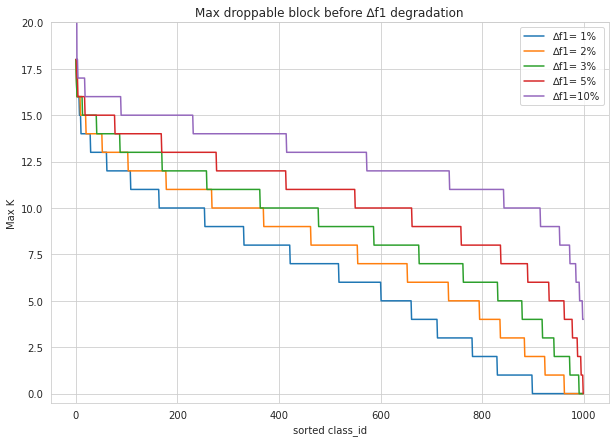

In [25]:
plt.figure(figsize=[10,7])
plt.title("Max droppable block before ∆f1 degradation")
avg_K_per_threshold = []
avg_f1_per_threshold = []
T = [0.01, 0.02, 0.03, 0.05, 0.10]
for threshold in T:
    max_block_drop_per_class, max_f1_per_class = compute_max_block_drop(threshold)
    avg_K_per_threshold.append(max_block_drop_per_class.mean().item())
    avg_f1_per_threshold.append(max_f1_per_class.mean().item())
    plt.plot(max_block_drop_per_class.sort(descending=True).values, label=f"∆f1={threshold*100:2.0f}%")
plt.xlabel("sorted class_id")
plt.ylabel("Max K")
plt.legend()
plt.ylim(-.5, 20)

In [21]:
for threshold in T[:1]:
    max_block_drop_per_class, max_f1_per_class = compute_max_block_drop(threshold)
    torch.save(max_block_drop_per_class, f"notebook-cache/swin/max_block_drop_per_class_at_delta{threshold:0.2f}.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

(array([101.,  69.,  49.,  69.,   0.,  51.,  60.,  83.,  96.,   0.,  91.,
         77.,  90.,   0.,  56.,  47.,  32.,  19.,   0.,   3.,   5.,   1.,
          1.]),
 array([ 0.       ,  0.7826087,  1.5652174,  2.347826 ,  3.1304348,
         3.9130435,  4.695652 ,  5.478261 ,  6.2608695,  7.0434785,
         7.826087 ,  8.608696 ,  9.391304 , 10.173913 , 10.956522 ,
        11.73913  , 12.521739 , 13.304348 , 14.086957 , 14.869565 ,
        15.652174 , 16.434782 , 17.217392 , 18.       ], dtype=float32),
 <BarContainer object of 23 artists>)

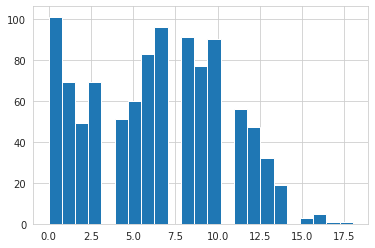

In [24]:
plt.hist(max_block_drop_per_class.numpy(), bins=23)

In [13]:
import numpy as np
import math
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

for t, x, y in zip(T, avg_K_per_threshold, avg_f1_per_threshold):
    nearest_k = round(x)
#     nearest_k = math.floor(x)
#     nearest_k = find_nearest(list(baselines_f1.keys()), x)
    baseline_f1 = baselines_f1[nearest_k]
    print(f"∆f1={t*100:2.0f}% : avg K={x:4.1f} : f1(mean)={y*100:>2.1f}% : static(K={nearest_k:2d}) f1={baseline_f1*100:>2.1f}%")

∆f1= 1% : avg K= 6.4 : f1(mean)=82.8% : static(K= 6) f1=80.7%
∆f1= 2% : avg K= 7.8 : f1(mean)=82.0% : static(K= 8) f1=79.5%
∆f1= 3% : avg K= 9.0 : f1(mean)=81.2% : static(K= 9) f1=78.5%
∆f1= 5% : avg K=10.5 : f1(mean)=79.6% : static(K=11) f1=76.7%
∆f1=10% : avg K=12.7 : f1(mean)=75.6% : static(K=13) f1=71.4%


In [67]:
for t, x, y in zip(T, avg_K_per_threshold, avg_f1_per_threshold):
    print(f"∆f1={t*100:2.0f}% : avg K={x:4.1f} : f1(mean)={y*100:>2.1f}%")

∆f1= 1% : avg K= 4.3 : f1(mean)=82.9%
∆f1= 5% : avg K= 8.3 : f1(mean)=80.3%
∆f1=10% : avg K=11.5 : f1(mean)=76.6%
∆f1=15% : avg K=13.5 : f1(mean)=72.1%
∆f1=25% : avg K=15.3 : f1(mean)=64.0%


In [110]:
for t, x, y in zip(T, avg_K_per_threshold, avg_f1_per_threshold):
    print(f"∆f1={t*100:2.0f}% : avg K={x:4.1f} : f1(mean)={y*100:>2.1f}%")

∆f1= 1% : avg K= 5.4 : f1(mean)=93.9%
∆f1= 5% : avg K= 9.1 : f1(mean)=91.3%
∆f1=10% : avg K=12.6 : f1(mean)=85.9%
∆f1=15% : avg K=14.0 : f1(mean)=81.3%
∆f1=25% : avg K=15.2 : f1(mean)=74.0%


In [77]:
k=0
train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
val_stats = torch.load(f"notebook-cache/swin/val_stats_k{k:02d}.pth")
best_f1_per_k = evaluate_for_K(train_stats, val_stats)["f1", "f1"]
best_f1_per_k.mean()

tensor(0.8262, dtype=torch.float16)

In [78]:
top1_bl = torch.load("./logs/swin/cache/val/full//24nCr0/all.pth")
(top1_bl["preds"] == top1_bl["targets"]).float().mean()

tensor(0.8289)

In [69]:
baseline.mean()

tensor(0.8262, dtype=torch.float16)

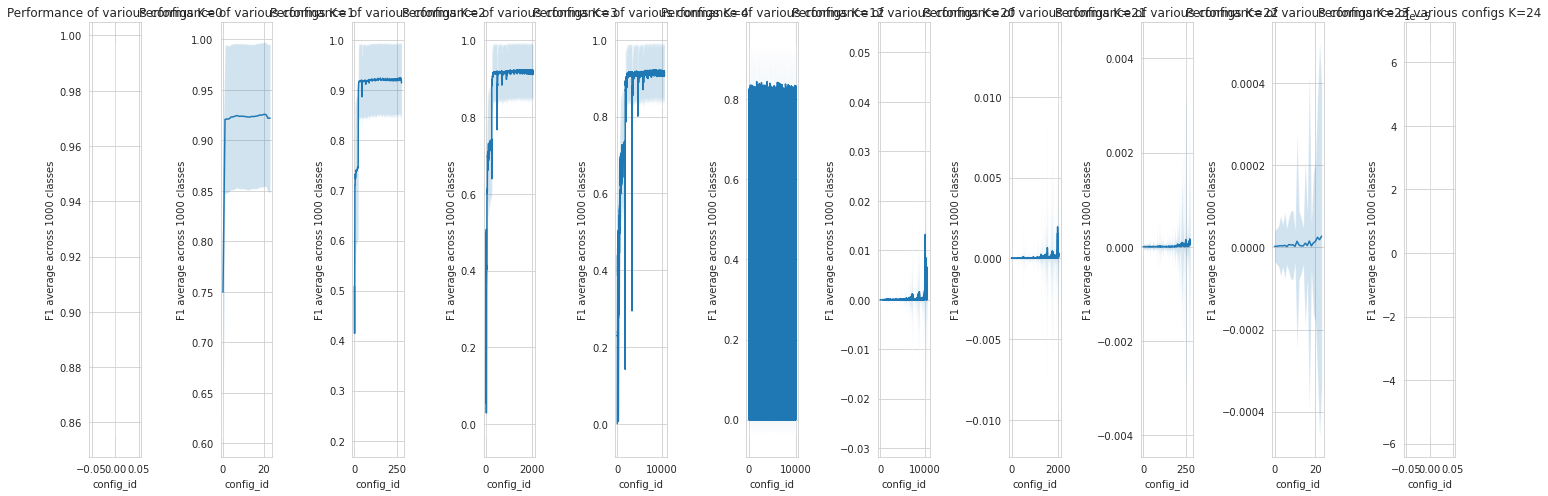

In [41]:

plt.figure(figsize=[20, 7])
for i, k in enumerate(K, start=1):
    
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    
    plt.subplot(1, len(K) , i)
    plt.title(f"Performance of various configs K={k}")
    plt.plot(train_stats["f1"][0].mean(dim=0))
    mean_f1 = train_stats["f1"][0].mean(dim=0)
    std_f1 = train_stats["f1"][0].std(dim=0)
    min_f1 = train_stats["f1"][0].min(dim=0)[0]
    max_f1 = train_stats["f1"][0].max(dim=0)[0]
    plt.fill_between(range(train_stats["f1"].shape[-1]), mean_f1-std_f1, mean_f1+std_f1, alpha=0.2)
    plt.ylabel("F1 average across 1000 classes")
    plt.xlabel("config_id")
    plt.tight_layout()

In [50]:
k = 4
val_data = torch.load(f"./logs/swin/cache/val/full/24nCr{k}/all.pth")
train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")

In [51]:
val_data["preds"].shape

torch.Size([10626, 50000])

In [52]:
def oracle_top1(val_data, train_stats, surrogate_metric="f1"):
    # val_data dims: [configs, samples]
    # train_stats dims: [proportion, classes, configs]
    preds = val_data["preds"]
    targets = val_data["targets"]
    
    num_configs = preds.shape[0]
    num_samples = preds.shape[1]
    num_proportions = train_stats[surrogate_metric].shape[0]
    num_classes = train_stats[surrogate_metric].shape[1]
    
    # select best config on average
    best_avg_id = train_stats["top1_acc"][0, 0].argmax()
    best_avg_top1 = (preds[best_avg_id] == targets[best_avg_id]).sum() / num_samples
    
    
    config_score = train_stats[surrogate_metric]
    # we're just interested in the full training data scores
    config_score = config_score[-1]
    

    #TODO: vectorise

    num_correct = 0
    class_id = 0
    i = 0
    for class_id in range(num_classes):
        config_id = config_score[class_id].argmax()
#         config_id = best_avg_id
        
        # Where are we dealing with samples of class_id
        selection_mask = targets[config_id] == class_id
        oracle_preds = preds[config_id][selection_mask]
        num_correct += (targets[config_id][selection_mask] == oracle_preds).sum()
        
    oracle_top1 = num_correct / num_samples
    return best_avg_top1, oracle_top1

In [53]:
oracle_top1(val_data, train_stats)

(tensor(0.8182), tensor(0.8146))

In [36]:
oracle_top1(val_data, train_stats, "class_level_acc")

hol up, sorting is under way
sort done


(tensor(0.8235), tensor(0.8161))

In [56]:
for k in K:
    val_data = torch.load(f"./logs/swin/cache/val/full/24nCr{k}/all.pth")
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    print(k)
    for surr in train_stats.keys():
        if "class" in surr:
            continue
        print(f"{surr:10}{oracle_top1(val_data, train_stats, surr)[1].item():1.4f}")

1
prec      0.8037
rec       0.8273
f1        0.8250
top1_acc  0.8285
2
prec      0.7398
rec       0.8240
f1        0.8210
top1_acc  0.8259
3
prec      0.5305
rec       0.8223
f1        0.8195
top1_acc  0.8235
4
prec      0.2758
rec       0.8210
f1        0.8146
top1_acc  0.8182


In [ ]:
plt.barh()

## Class level accuracy vs Top1 accuracy

In [68]:
preds = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 9, 8])
targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


def class_level_acc(preds, targets):
    acc = []
    TP = preds == targets
    for class_id in range(10):
        pred_mask = preds == class_id
        target_mask = targets == class_id
        class_tp = (TP * pred_mask).sum()
        class_tn = (~pred_mask * ~target_mask).sum()
        class_acc = (class_tp + class_tn) / len(preds)
        acc.append(class_acc)
    return torch.stack(acc)

def top1_acc(preds, targets):
    acc = (preds == targets).sum() / len(preds)
    return acc
    
class_level_acc(preds, targets), top1_acc(preds, targets)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8000,
         0.8000]),
 tensor(0.8000))

In [22]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")

In [5]:
stat_grid["f1", "f1", 4, "mean"]

tensor([0.8130])

In [158]:
# proportions = torch.linspace(0.2, 1.0, 50)
proportions = [0.5, 1.0]


# stat_grid = {}
# for k in range(17):
# for k in [0, 3, 4, 5, 6, 7]:
# for k in [8]:

# for k in [0, 1, 2, 3, 4, 20, 21, 22, 23, 24]:
# K = [0, 1, 2, 3, 21, 22, 23, 24]
# K = [0, 1, 2, 3, 4]
# K = [20, 21, 22, 23, 24]
# K = [12]
# K = [17]

for k in K:
    print(f"Aggregating validation statistics for K={k}")
    val_stats = train(
        f"./logs/swin/cache/val/full//24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth", 
        proportions=proportions
    )
    torch.save(val_stats, f"notebook-cache/swin/val_stats_k{k:02d}.pth")

Aggregating validation statistics for K=17


  0%|          | 0/1000 [00:00<?, ?it/s]

In [162]:
train_stats["f1"].shape, val_stats["f1"].shape

(torch.Size([1, 1000, 276]), torch.Size([2, 1000, 10000]))

In [ ]:
for k in K:
    print(f"Aggregating training statistics for K={k}")
    train_stats = train(
        f"./logs/swin/cache/train/0.1/24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth", 
        proportions=proportions
    )
    torch.save(train_stats, f"notebook-cache/swin/train_stats_k{k:02d}.pth")

In [135]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")
# K = [0, 1, 2, 3, 4, 12, 13, 20, 21, 22, 23, 24]
# stat_grid = {}
for k in K:
    print(f"Aggregating validation statistics K =", k)
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    for surrogate_metric_name, surrogate_scores in train_stats.items():
        print(surrogate_metric_name)
        val_stats = evaluate_old(
            f"./logs/swin/cache/val/full/24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth",
            surrogate_scores,
            proportions
        )
        for val_metric_name, val_scores in val_stats.items():
            stat_grid[surrogate_metric_name, val_metric_name, k, "mean"] = val_scores.mean(dim=1)
            stat_grid[surrogate_metric_name, val_metric_name, k, "std"] = val_scores.std(dim=1)
            

Aggregating validation statistics K = 17
prec


  0%|          | 0/2 [00:00<?, ?it/s]

rec


  0%|          | 0/2 [00:00<?, ?it/s]

f1


  0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
K = [0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24]

In [146]:
torch.save(stat_grid, "notebook-cache/swin/stat_grid_5metrics.pth")

In [147]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")

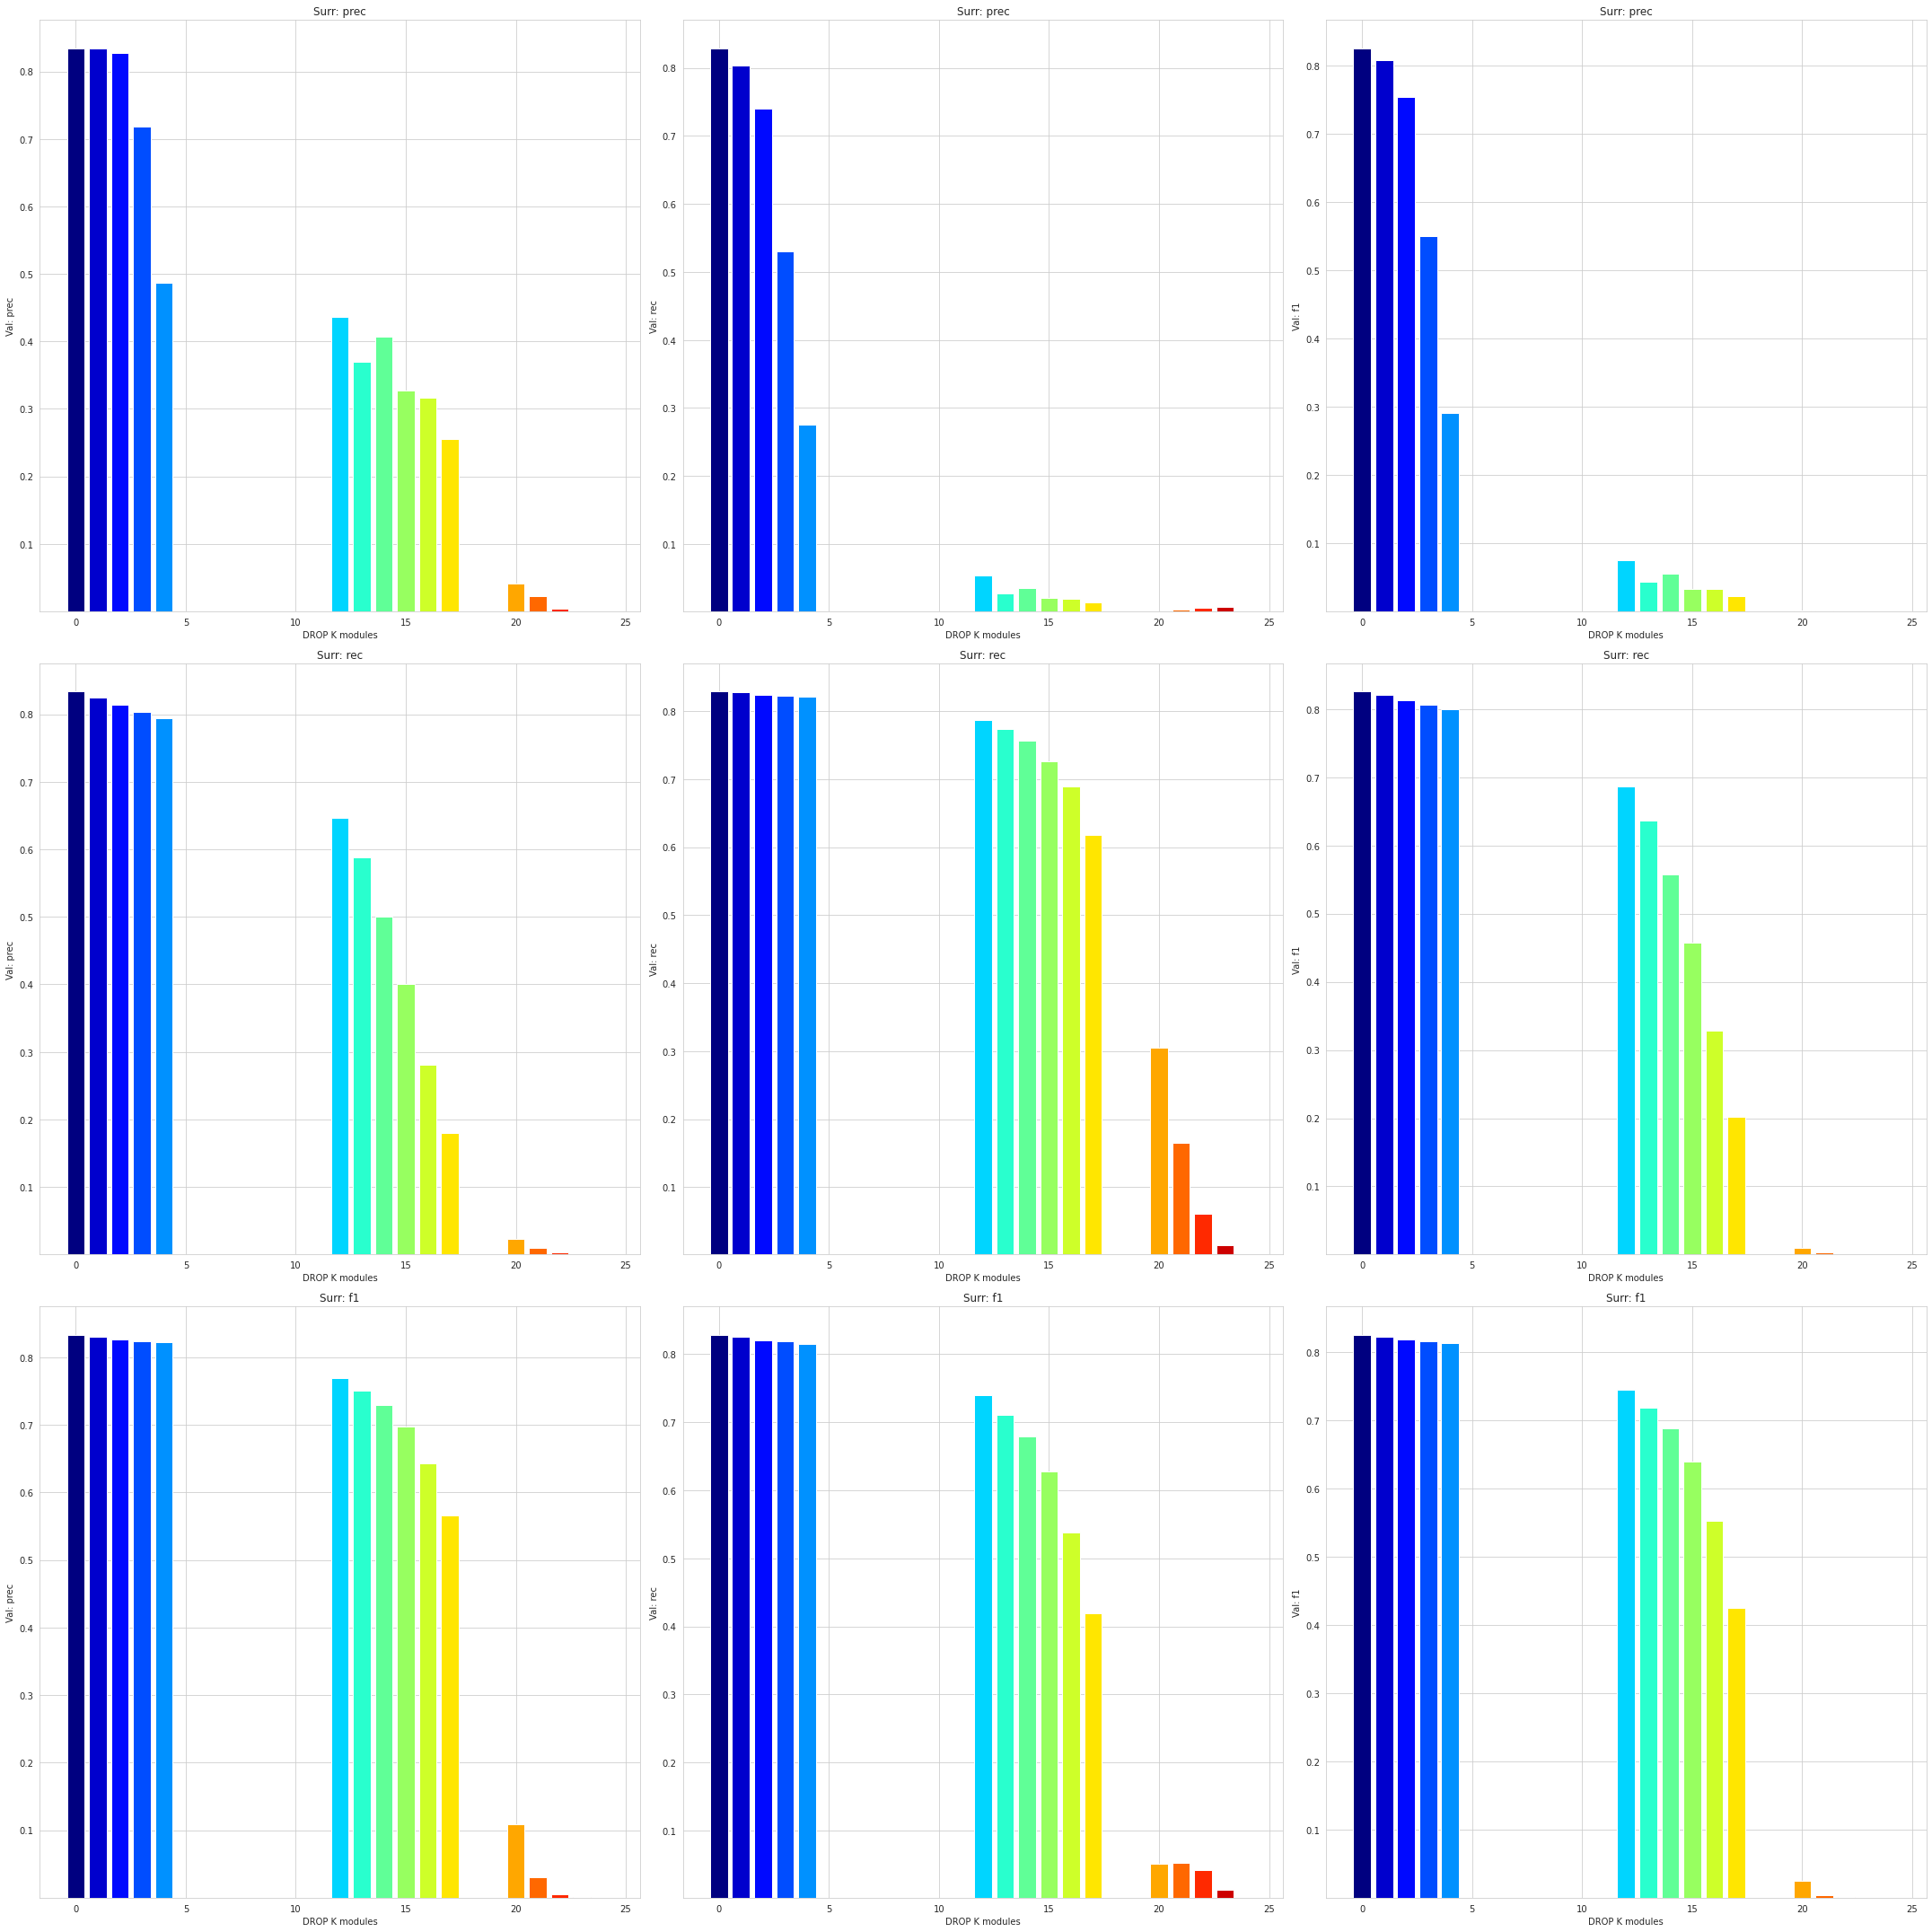

In [148]:
colors = plt.cm.jet(torch.linspace(0,1,len(K)).numpy())
metrics = train_stats.keys()
plt.figure(figsize=[30, 30])
fig_counter = 0
for surrogate_metric in metrics:
    for val_metric in metrics:        
        fig_counter += 1
        plt.subplot(len(metrics), len(metrics), fig_counter)
        plt.title(f"Surr: {surrogate_metric}")
        ys = [stat_grid[surrogate_metric, val_metric, k, "mean"][-1].numpy() for k in K]
        ymin = min(ys) - 0.05 * min(ys)
        ymax = max(ys) + 0.05 * max(ys)
        
        plt.bar(K, ys, color=colors)
        plt.ylim(ymin, ymax)
        plt.ylabel(f"Val: {val_metric}")
        plt.xlabel("DROP K modules")

plt.tight_layout()

In [76]:
for k in K:
    print(stat_grid["f1", "f1", k, "mean"].item(), stat_grid["f1", "f1", k, "std"].item())

0.8259482383728027 0.13536594808101654
0.8224653005599976 0.1357399821281433
0.8182122111320496 0.1362585872411728
0.8163348436355591 0.13552850484848022
0.8130437135696411 0.1368642896413803
0.745379626750946 0.16081495583057404
0.718688428401947 0.17021998763084412
0.6888388395309448 0.1805424839258194
0.024393457919359207 0.06295251846313477
0.004309267271310091 0.01938995160162449
0.0008170130313374102 0.01051342859864235
0.00010341181041439995 0.0007899014744907618
3.662109293145477e-06 4.477894617593847e-05


Text(0, 0.5, 'F1 score (using F1 to select best config)')

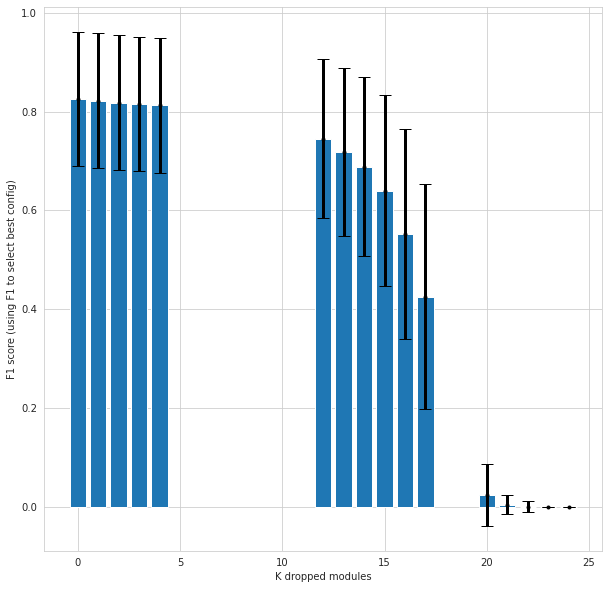

In [149]:
plt.figure(figsize=[10,10])
f1_mean = [stat_grid["f1", "f1", k, "mean"][-1].item() for k in K]
f1_std = [stat_grid["f1", "f1", k, "std"][-1].item() for k in K]
plt.bar(K, f1_mean)
plt.errorbar(K, f1_mean, yerr=f1_std, fmt='.k', ecolor="black", elinewidth=3, capsize=6)
plt.xlabel("K dropped modules")
plt.ylabel("F1 score (using F1 to select best config)")

## Analysis of block usage

In [59]:
# K = [1, 2, 3, 21, 22, 23]
# K = [1, 2, 3, 4]

block_heatmap = {}
for k in K:
    
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    configs = json.load(open(f"qbes_configs/24nCr{k}.json"))

    block_heatmap_k = [0]*24
    for class_id in range(1000):
        class_best_config = configs[train_stats["f1"][-1][class_id].argmax()]
        for block_id in class_best_config:
            block_heatmap_k[block_id] += 1
    
    block_heatmap[k] = block_heatmap_k

In [61]:
normalized_block_heatmap = {}
for k in K:
    block_heatmap_k = block_heatmap[k]
    total = sum(block_heatmap_k)+1
    normalized_block_heatmap[k] = [x/total for x in block_heatmap_k]

In [62]:
import pandas as pd

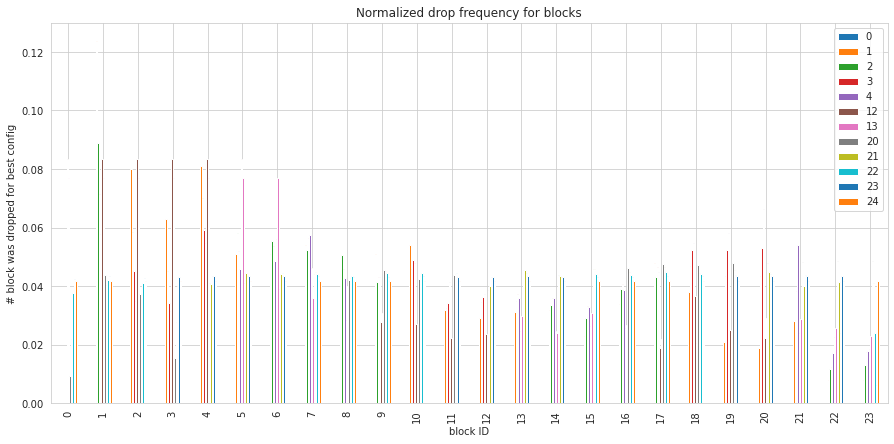

In [63]:
block_heatmap
df = pd.DataFrame(normalized_block_heatmap, columns=block_heatmap.keys())

df.plot(kind="bar", figsize=[15, 7])
plt.xlabel("block ID")
plt.ylabel("# block was dropped for best config")
plt.title("Normalized drop frequency for blocks")
_ = _

Text(0.5, 1.0, 'F1 scores of sorted configs across randomly selected classes')

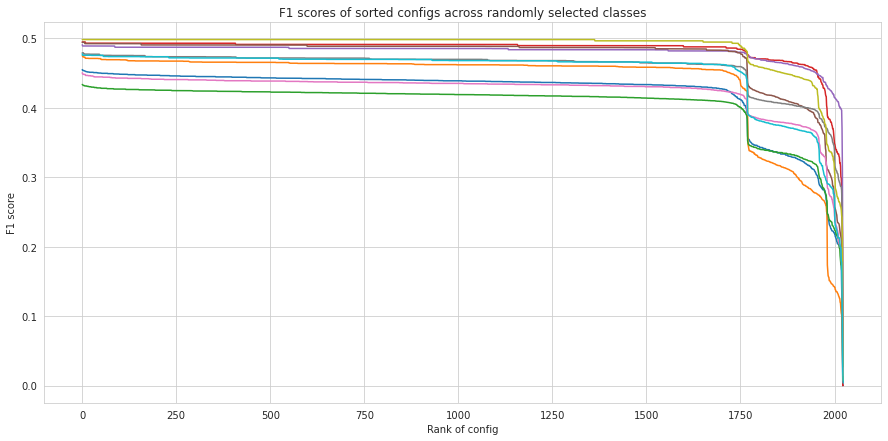

In [106]:
plt.figure(figsize=[15, 7])
plt.plot(torch.sort(train_stats["f1"][0, torch.randint(train_stats["f1"].shape[1], [10])], descending=True)[0].numpy().T)
plt.xlabel("Rank of config")
plt.ylabel("F1 score")
plt.title("F1 scores of sorted configs across randomly selected classes")

Text(0.5, 0, 'config_id')

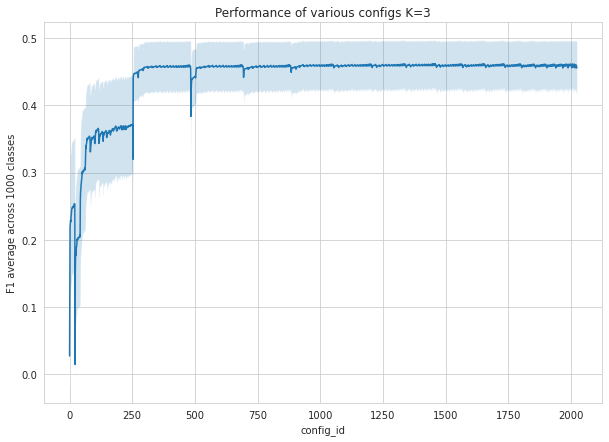

In [120]:
plt.figure(figsize=[10, 7])
plt.title("Performance of various configs K=3")
plt.plot(train_stats["f1"][0].mean(dim=0))
mean_f1 = train_stats["f1"][0].mean(dim=0)
std_f1 = train_stats["f1"][0].std(dim=0)
min_f1 = train_stats["f1"][0].min(dim=0)[0]
max_f1 = train_stats["f1"][0].max(dim=0)[0]
plt.fill_between(range(train_stats["f1"].shape[-1]), mean_f1-std_f1, mean_f1+std_f1, alpha=0.2)
plt.ylabel("F1 average across 1000 classes")
plt.xlabel("config_id")

In [204]:
baseline_config = mean_f1.argmax()
baseline_f1 = train_stats["f1"][0, :, baseline_config]
best_f1_per_class = train_stats["f1"][0].max(dim=1).values

# deltas = torch.sort(best_f1_per_class-baseline_f1, descending=True).values

In [205]:
baseline_config

tensor(1458)

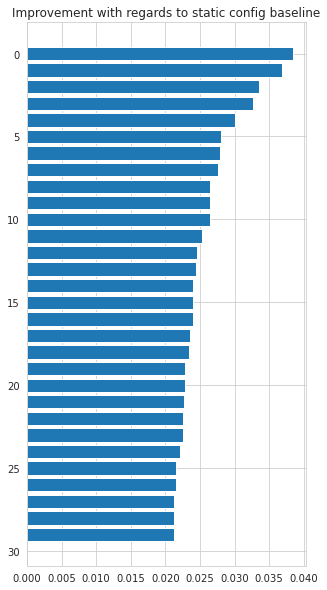

In [171]:
plt.figure(figsize=[5, 10])
plt.title("Improvement with regards to static config baseline")
# plt.xlabel("ranked class_id")
# plt.ylabel("F1 improvement over baseline")
# plt.fill_between(range(1000), [0]*1000, deltas.numpy())
plt.barh(range(30), deltas[:30].numpy())
plt.gca().invert_yaxis()

In [156]:
best_f1_per_K = [stat_grid["f1", "f1", k, "mean"] for k in K]

In [27]:
evaluate_for_K(train_stats, val_stats)["f1", "f1"].shape

torch.Size([1000])

In [22]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")

In [5]:
stat_grid["f1", "f1", 4, "mean"]

tensor([0.8130])

In [158]:
# proportions = torch.linspace(0.2, 1.0, 50)
proportions = [0.5, 1.0]


# stat_grid = {}
# for k in range(17):
# for k in [0, 3, 4, 5, 6, 7]:
# for k in [8]:

# for k in [0, 1, 2, 3, 4, 20, 21, 22, 23, 24]:
# K = [0, 1, 2, 3, 21, 22, 23, 24]
# K = [0, 1, 2, 3, 4]
# K = [20, 21, 22, 23, 24]
# K = [12]
# K = [17]

for k in K:
    print(f"Aggregating validation statistics for K={k}")
    val_stats = train(
        f"./logs/swin/cache/val/full//24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth", 
        proportions=proportions
    )
    torch.save(val_stats, f"notebook-cache/swin/val_stats_k{k:02d}.pth")

Aggregating validation statistics for K=17


  0%|          | 0/1000 [00:00<?, ?it/s]

In [162]:
train_stats["f1"].shape, val_stats["f1"].shape

(torch.Size([1, 1000, 276]), torch.Size([2, 1000, 10000]))

In [ ]:
for k in K:
    print(f"Aggregating training statistics for K={k}")
    train_stats = train(
        f"./logs/swin/cache/train/0.1/24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth", 
        proportions=proportions
    )
    torch.save(train_stats, f"notebook-cache/swin/train_stats_k{k:02d}.pth")

In [135]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")
# K = [0, 1, 2, 3, 4, 12, 13, 20, 21, 22, 23, 24]
# stat_grid = {}
for k in K:
    print(f"Aggregating validation statistics K =", k)
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    for surrogate_metric_name, surrogate_scores in train_stats.items():
        print(surrogate_metric_name)
        val_stats = evaluate_old(
            f"./logs/swin/cache/val/full/24nCr{k}{'-10k' if (k>4 and k<20) else ''}/all.pth",
            surrogate_scores,
            proportions
        )
        for val_metric_name, val_scores in val_stats.items():
            stat_grid[surrogate_metric_name, val_metric_name, k, "mean"] = val_scores.mean(dim=1)
            stat_grid[surrogate_metric_name, val_metric_name, k, "std"] = val_scores.std(dim=1)
            

Aggregating validation statistics K = 17
prec


  0%|          | 0/2 [00:00<?, ?it/s]

rec


  0%|          | 0/2 [00:00<?, ?it/s]

f1


  0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
K = [0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24]

In [146]:
torch.save(stat_grid, "notebook-cache/swin/stat_grid_5metrics.pth")

In [147]:
stat_grid = torch.load("notebook-cache/swin/stat_grid_5metrics.pth")

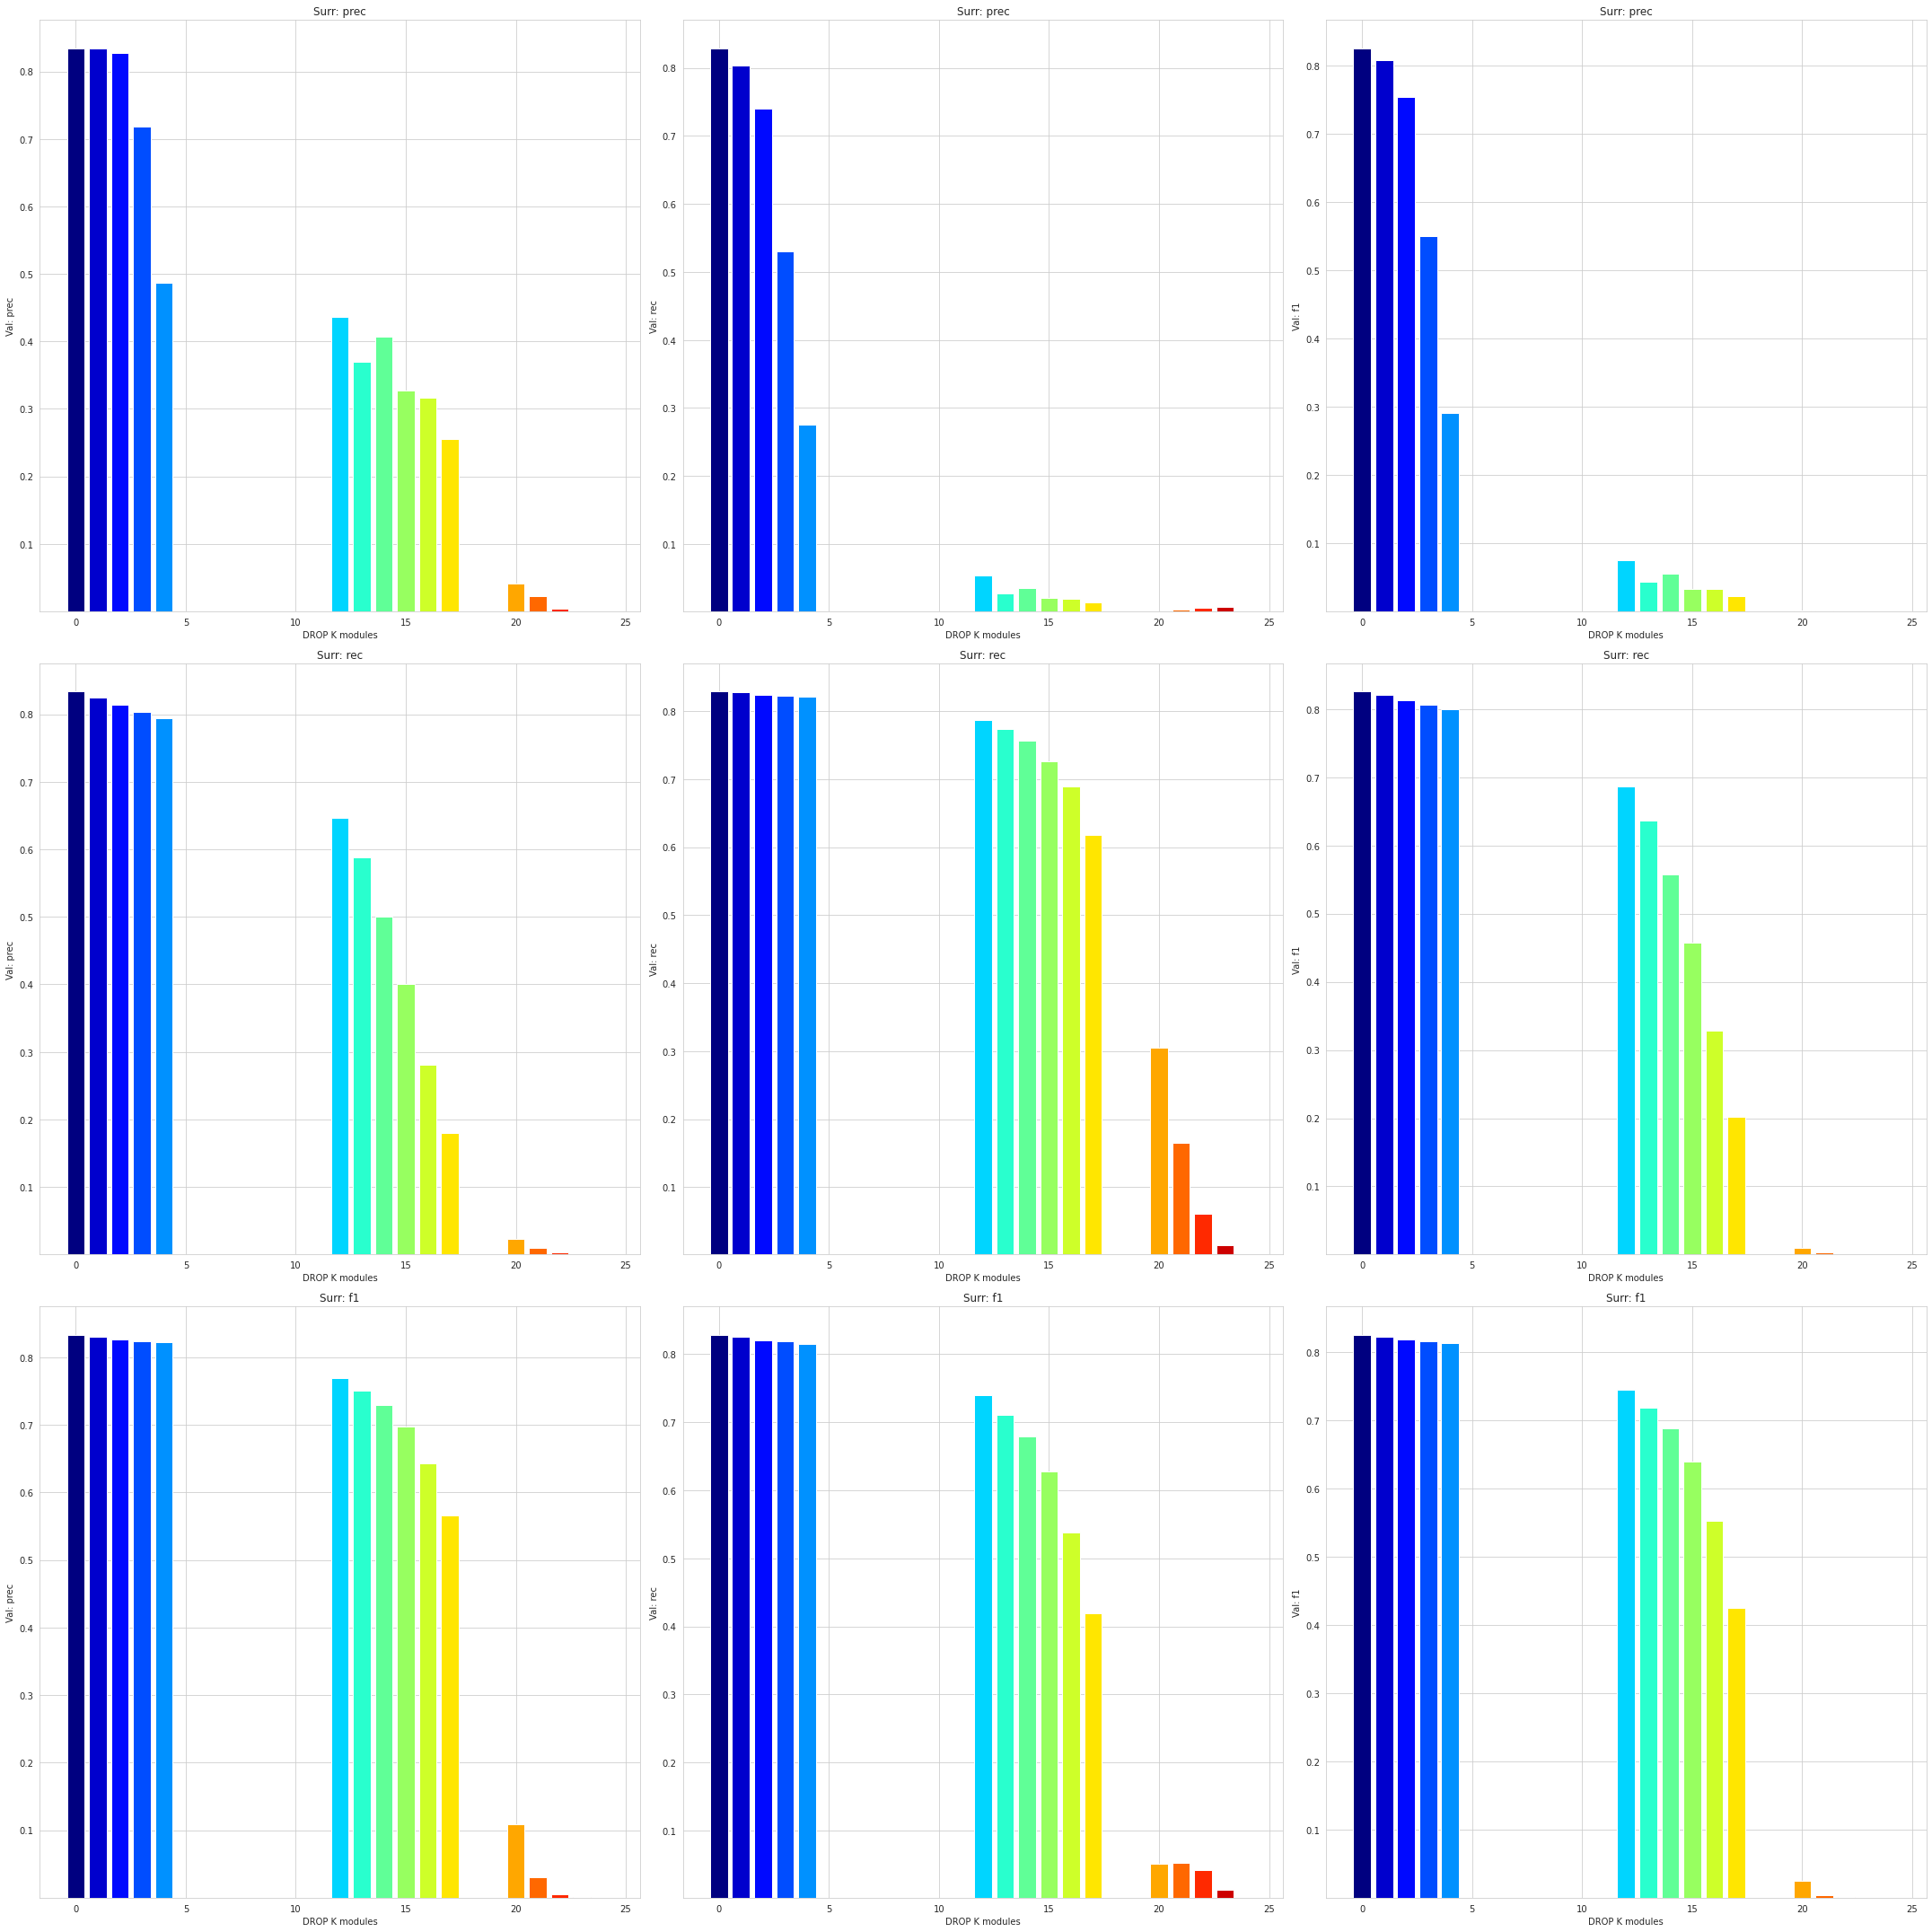

In [148]:
colors = plt.cm.jet(torch.linspace(0,1,len(K)).numpy())
metrics = train_stats.keys()
plt.figure(figsize=[30, 30])
fig_counter = 0
for surrogate_metric in metrics:
    for val_metric in metrics:        
        fig_counter += 1
        plt.subplot(len(metrics), len(metrics), fig_counter)
        plt.title(f"Surr: {surrogate_metric}")
        ys = [stat_grid[surrogate_metric, val_metric, k, "mean"][-1].numpy() for k in K]
        ymin = min(ys) - 0.05 * min(ys)
        ymax = max(ys) + 0.05 * max(ys)
        
        plt.bar(K, ys, color=colors)
        plt.ylim(ymin, ymax)
        plt.ylabel(f"Val: {val_metric}")
        plt.xlabel("DROP K modules")

plt.tight_layout()

In [76]:
for k in K:
    print(stat_grid["f1", "f1", k, "mean"].item(), stat_grid["f1", "f1", k, "std"].item())

0.8259482383728027 0.13536594808101654
0.8224653005599976 0.1357399821281433
0.8182122111320496 0.1362585872411728
0.8163348436355591 0.13552850484848022
0.8130437135696411 0.1368642896413803
0.745379626750946 0.16081495583057404
0.718688428401947 0.17021998763084412
0.6888388395309448 0.1805424839258194
0.024393457919359207 0.06295251846313477
0.004309267271310091 0.01938995160162449
0.0008170130313374102 0.01051342859864235
0.00010341181041439995 0.0007899014744907618
3.662109293145477e-06 4.477894617593847e-05


Text(0, 0.5, 'F1 score (using F1 to select best config)')

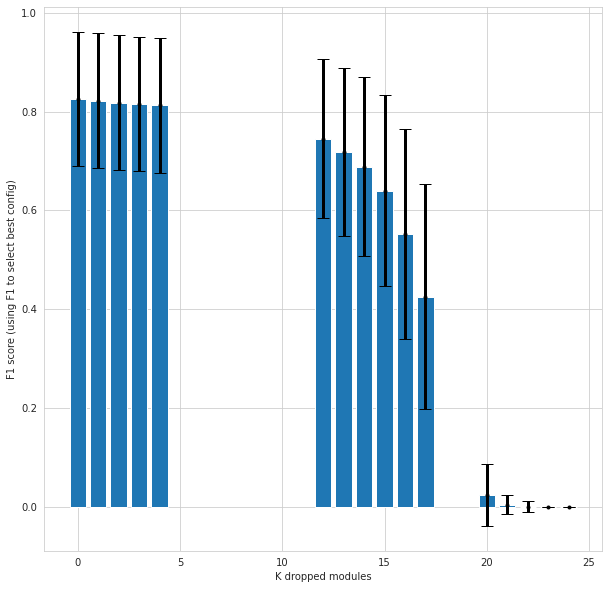

In [149]:
plt.figure(figsize=[10,10])
f1_mean = [stat_grid["f1", "f1", k, "mean"][-1].item() for k in K]
f1_std = [stat_grid["f1", "f1", k, "std"][-1].item() for k in K]
plt.bar(K, f1_mean)
plt.errorbar(K, f1_mean, yerr=f1_std, fmt='.k', ecolor="black", elinewidth=3, capsize=6)
plt.xlabel("K dropped modules")
plt.ylabel("F1 score (using F1 to select best config)")

## Analysis of block usage

In [59]:
# K = [1, 2, 3, 21, 22, 23]
# K = [1, 2, 3, 4]

block_heatmap = {}
for k in K:
    
    train_stats = torch.load(f"notebook-cache/swin/train_stats_k{k:02d}.pth")
    configs = json.load(open(f"qbes_configs/24nCr{k}.json"))

    block_heatmap_k = [0]*24
    for class_id in range(1000):
        class_best_config = configs[train_stats["f1"][-1][class_id].argmax()]
        for block_id in class_best_config:
            block_heatmap_k[block_id] += 1
    
    block_heatmap[k] = block_heatmap_k

In [61]:
normalized_block_heatmap = {}
for k in K:
    block_heatmap_k = block_heatmap[k]
    total = sum(block_heatmap_k)+1
    normalized_block_heatmap[k] = [x/total for x in block_heatmap_k]

In [62]:
import pandas as pd

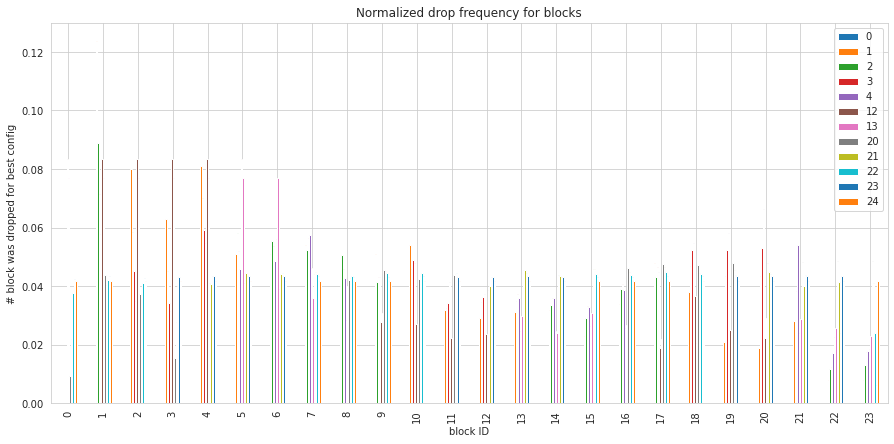

In [63]:
block_heatmap
df = pd.DataFrame(normalized_block_heatmap, columns=block_heatmap.keys())

df.plot(kind="bar", figsize=[15, 7])
plt.xlabel("block ID")
plt.ylabel("# block was dropped for best config")
plt.title("Normalized drop frequency for blocks")
_ = _

Text(0.5, 1.0, 'F1 scores of sorted configs across randomly selected classes')

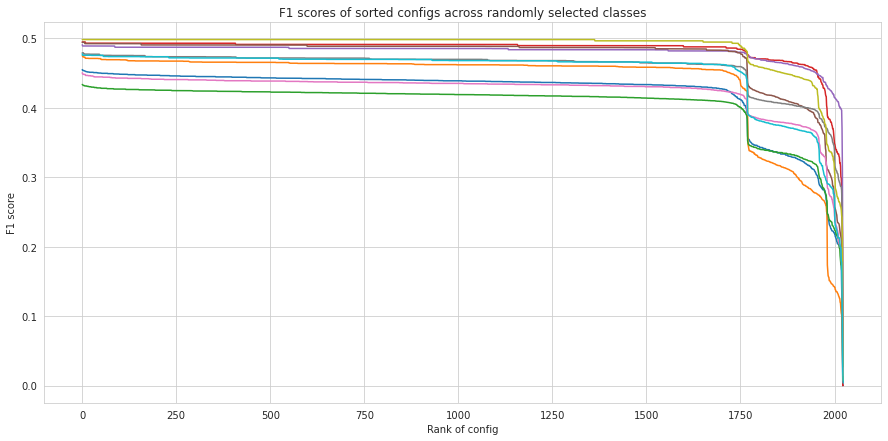

In [106]:
plt.figure(figsize=[15, 7])
plt.plot(torch.sort(train_stats["f1"][0, torch.randint(train_stats["f1"].shape[1], [10])], descending=True)[0].numpy().T)
plt.xlabel("Rank of config")
plt.ylabel("F1 score")
plt.title("F1 scores of sorted configs across randomly selected classes")

Text(0.5, 0, 'config_id')

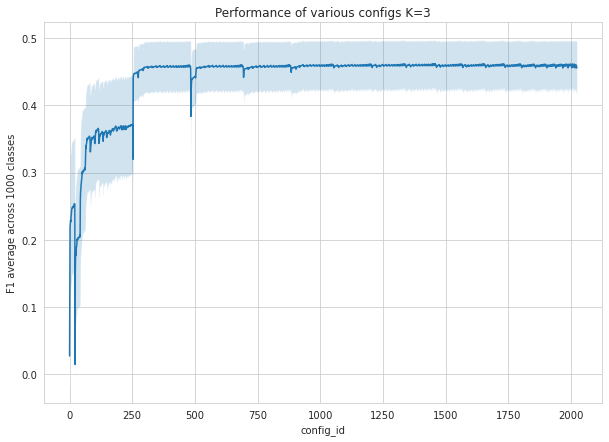

In [120]:
plt.figure(figsize=[10, 7])
plt.title("Performance of various configs K=3")
plt.plot(train_stats["f1"][0].mean(dim=0))
mean_f1 = train_stats["f1"][0].mean(dim=0)
std_f1 = train_stats["f1"][0].std(dim=0)
min_f1 = train_stats["f1"][0].min(dim=0)[0]
max_f1 = train_stats["f1"][0].max(dim=0)[0]
plt.fill_between(range(train_stats["f1"].shape[-1]), mean_f1-std_f1, mean_f1+std_f1, alpha=0.2)
plt.ylabel("F1 average across 1000 classes")
plt.xlabel("config_id")

In [204]:
baseline_config = mean_f1.argmax()
baseline_f1 = train_stats["f1"][0, :, baseline_config]
best_f1_per_class = train_stats["f1"][0].max(dim=1).values

# deltas = torch.sort(best_f1_per_class-baseline_f1, descending=True).values

In [205]:
baseline_config

tensor(1458)

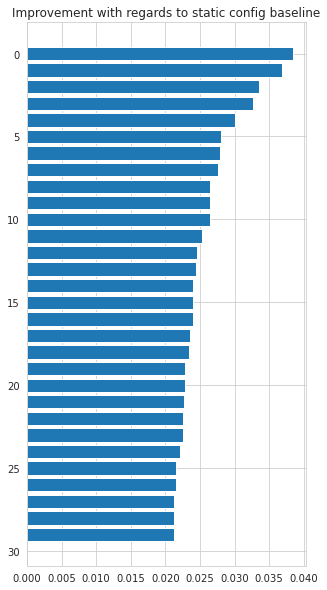

In [171]:
plt.figure(figsize=[5, 10])
plt.title("Improvement with regards to static config baseline")
# plt.xlabel("ranked class_id")
# plt.ylabel("F1 improvement over baseline")
# plt.fill_between(range(1000), [0]*1000, deltas.numpy())
plt.barh(range(30), deltas[:30].numpy())
plt.gca().invert_yaxis()

In [156]:
best_f1_per_K = [stat_grid["f1", "f1", k, "mean"] for k in K]

In [27]:
evaluate_for_K(train_stats, val_stats)["f1", "f1"].shape

torch.Size([1000])

In [125]:
prec_focused_numblockdropped_vs_prec = {}
prec_focused_numblockdropped_vs_rec = {}
proportions = torch.linspace(0.01, 1.0, 100)
torch.cuda.empty_cache()

# for k in [0, 3, 4, 5, 6, 7]:
for k in [0]:
    proportion_vs_prec = {}
    proportion_vs_rec = {}
    train_class_vs_config_prec, train_class_vs_config_rec = process_configs_train(
        f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth", 
        proportions=proportions
    )
    val_precs, val_recs = evaluate(
        f"./logs/cache/val/16nCr{k}.pth",
        train_class_vs_config_prec, 
        proportions
    )
    for proportion, val_prec, val_rec in zip(proportions, val_precs, val_recs):
        proportion_vs_prec[proportion.item()] = val_prec.mean().item()
        proportion_vs_rec[proportion.item()] = val_rec.mean().item()
        
    prec_focused_numblockdropped_vs_prec[k] = proportion_vs_prec
    prec_focused_numblockdropped_vs_rec[k] = proportion_vs_rec

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'num of best performing classes')

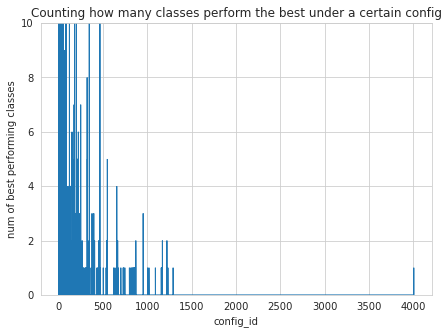

In [128]:
plt.figure(figsize=[7, 5])
num_configs = train_class_vs_config_prec.shape[-1]
best_configs_per_class = train_class_vs_config_prec[-1].cpu().argmax(dim=1).numpy()
plt.hist(best_configs_per_class, num_configs, histtype="step")
plt.ylim(0, 10)
plt.title("Counting how many classes perform the best under a certain config")
plt.xlabel("config_id")
plt.ylabel("num of best performing classes")

In [18]:
torch.save(numblockdropped_vs_prec, "precision_focus_numblockdropped_vs_prec_3-7_incomplete5_0.01-1.0_step100.pth")
torch.save(numblockdropped_vs_rec, "precision_focus_numblockdropped_vs_rec_3-7_incomplete5_0.01-1.0_step100.pth")

#### It seems that the `best precision per class` histogram is a lot more clustered

In [19]:
numblockdropped_vs_prec = torch.load("precision_focus_numblockdropped_vs_prec_3-7_incomplete5_0.01-1.0_step100.pth")
numblockdropped_vs_rec = torch.load("precision_focus_numblockdropped_vs_rec_3-7_incomplete5_0.01-1.0_step100.pth")

proportions = torch.linspace(0.01, 1.0, 100)

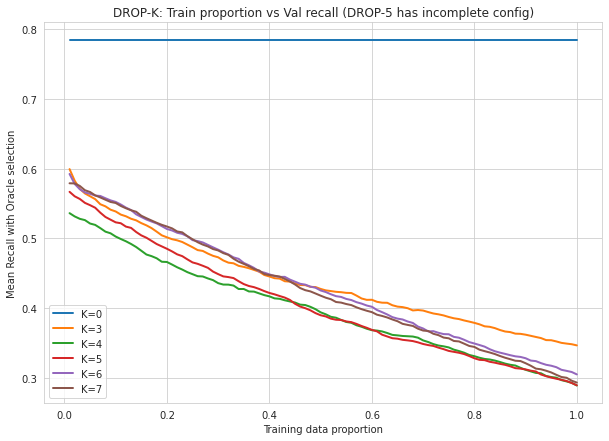

In [129]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val recall (DROP-5 has incomplete config)")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_rec = prec_focused_numblockdropped_vs_rec[k]
    plt.plot(proportions, proportion_vs_rec.values(), label=f"K={k}", lw=2, alpha=alpha)

plt.xlabel("Training data proportion")
plt.ylabel("Mean Recall with Oracle selection")
plt.legend()
plt.show()

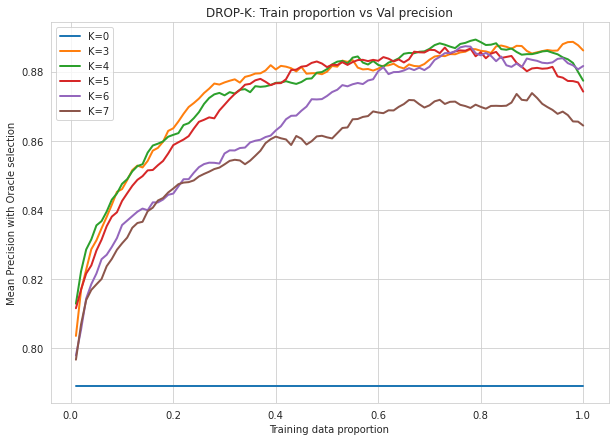

In [130]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val precision")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_prec = prec_focused_numblockdropped_vs_prec[k]
    plt.plot(proportions, proportion_vs_prec.values(), label=f"K={k}", lw=2)

plt.xlabel("Training data proportion")
plt.ylabel("Mean Precision with Oracle selection")
plt.legend()
plt.show()

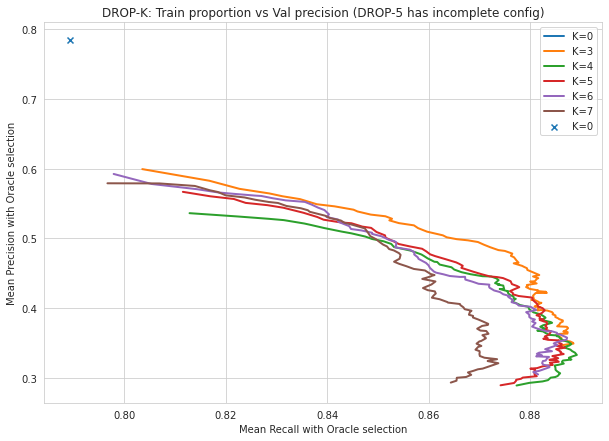

In [133]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val precision (DROP-5 has incomplete config)")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_prec = prec_focused_numblockdropped_vs_prec[k]
    proportion_vs_rec = prec_focused_numblockdropped_vs_rec[k]


    plt.plot(proportion_vs_prec.values(), proportion_vs_rec.values(), label=f"K={k}", lw=2)

    
plt.scatter([numblockdropped_vs_prec[0][1.0]], [numblockdropped_vs_rec[0][1.0]], marker="x", label="K=0")
plt.xlabel("Mean Recall with Oracle selection")
plt.ylabel("Mean Precision with Oracle selection")
plt.legend()
plt.show()

## Some less ridiculous plot of precision

Text(0, 0.5, 'Avg Recall')

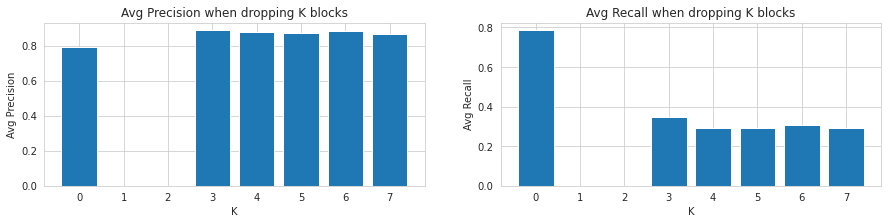

In [137]:
K = [0, 3, 4, 5, 6, 7]

plt.figure(figsize=[15, 3])
plt.subplot(1, 2, 1)
prec_per_dropblock = [prec_focused_numblockdropped_vs_prec[k][1.0] for k in K]
plt.title("Avg Precision when dropping K blocks")
plt.bar(K, prec_per_dropblock)
plt.xlabel("K")
plt.ylabel("Avg Precision")


plt.subplot(1, 2, 2)
prec_per_dropblock = [prec_focused_numblockdropped_vs_rec[k][1.0] for k in K]
plt.title("Avg Recall when dropping K blocks")
plt.bar(K, prec_per_dropblock)
plt.xlabel("K")
plt.ylabel("Avg Recall")

## Evaluate class precision and recall with finetuning for _*recall*_

In [135]:
recall_focused_numblockdropped_vs_prec = {}
recall_focused_numblockdropped_vs_rec = {}
proportions = torch.linspace(0.01, 1.0, 100)
torch.cuda.empty_cache()

for k in [0, 3, 4, 5, 6, 7]:
# for k in [6]:
    proportion_vs_prec = {}
    proportion_vs_rec = {}
    train_class_vs_config_prec, train_class_vs_config_rec = process_configs_train(
        f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth", 
        proportions=proportions
    )
    val_precs, val_recs = evaluate(
        f"./logs/cache/val/16nCr{k}.pth",
        train_class_vs_config_rec, 
        proportions
    )
    for proportion, val_prec, val_rec in zip(proportions, val_precs, val_recs):
        proportion_vs_prec[proportion.item()] = val_prec.mean().item()
        proportion_vs_rec[proportion.item()] = val_rec.mean().item()
        
    recall_focused_numblockdropped_vs_prec[k] = proportion_vs_prec
    recall_focused_numblockdropped_vs_rec[k] = proportion_vs_rec

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'num of best performing classes')

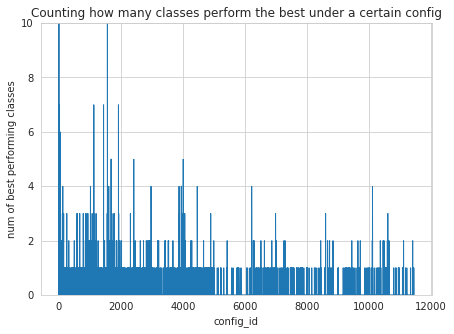

In [26]:
plt.figure(figsize=[7, 5])
num_configs = train_class_vs_config_prec.shape[-1]
best_configs_per_class = train_class_vs_config_rec[-1].cpu().argmax(dim=1).numpy()
plt.hist(best_configs_per_class, num_configs, histtype="step")
plt.ylim(0, 10)
plt.title("Counting how many classes perform the best under a certain config")
plt.xlabel("config_id")
plt.ylabel("num of best performing classes")

Text(0, 0.5, 'num of best performing classes')

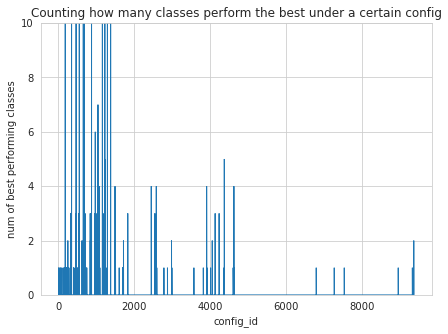

In [96]:
plt.figure(figsize=[7, 5])
num_configs = train_class_vs_config_prec.shape[-1]
best_configs_per_class = train_class_vs_config_prec[-1].cpu().argmax(dim=1).numpy()
plt.hist(best_configs_per_class, num_configs, histtype="step")
plt.ylim(0, 10)
plt.title("Counting how many classes perform the best under a certain config")
plt.xlabel("config_id")
plt.ylabel("num of best performing classes")

In [27]:
torch.save(recall_focused_numblockdropped_vs_prec, "recall_focused_numblockdropped_vs_prec_3-7_incomplete5_0.01-1.0_step100.pth")
torch.save(recall_focused_numblockdropped_vs_rec, "recall_focused_numblockdropped_vs_rec_3-7_incomplete5_0.01-1.0_step100.pth")

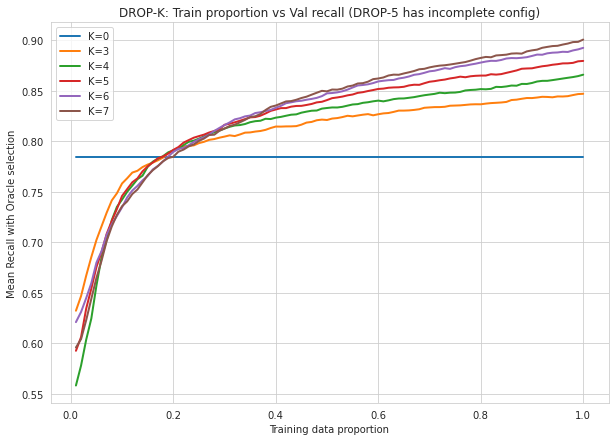

In [140]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val recall (DROP-5 has incomplete config)")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_rec = recall_focused_numblockdropped_vs_rec[k]
    plt.plot(proportions, proportion_vs_rec.values(), label=f"K={k}", lw=2)

plt.xlabel("Training data proportion")
plt.ylabel("Mean Recall with Oracle selection")
plt.legend()
plt.show()

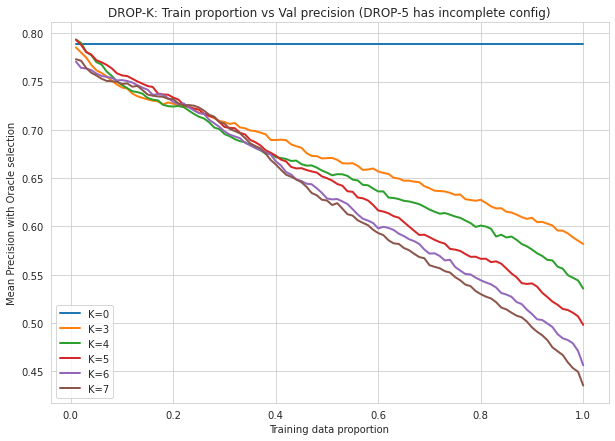

In [141]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val precision (DROP-5 has incomplete config)")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_prec = recall_focused_numblockdropped_vs_prec[k]
    plt.plot(proportions, proportion_vs_prec.values(), label=f"K={k}", lw=2)

plt.xlabel("Training data proportion")
plt.ylabel("Mean Precision with Oracle selection")
plt.legend()
plt.show()

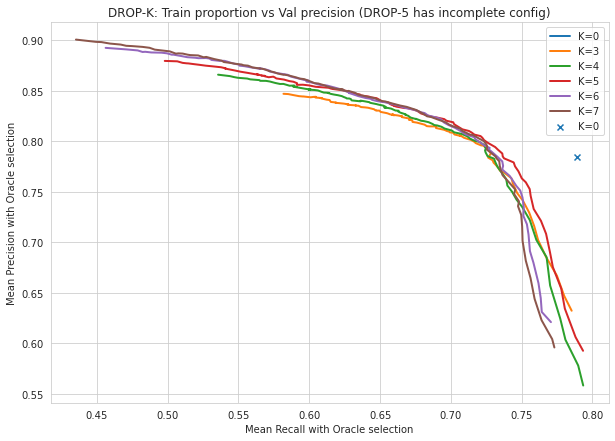

In [143]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
plt.title(f"DROP-K: Train proportion vs Val precision (DROP-5 has incomplete config)")
for i, k in enumerate([0, 3, 4, 5, 6, 7], start=1):
    proportion_vs_prec = recall_focused_numblockdropped_vs_prec[k]
    proportion_vs_rec = recall_focused_numblockdropped_vs_rec[k]
    plt.plot(proportion_vs_prec.values(), proportion_vs_rec.values(), label=f"K={k}", lw=2)

    
plt.scatter([numblockdropped_vs_prec[0][1.0]], [numblockdropped_vs_rec[0][1.0]], marker="x", label="K=0")
plt.xlabel("Mean Recall with Oracle selection")
plt.ylabel("Mean Precision with Oracle selection")
plt.legend()
plt.show()

Text(0, 0.5, 'Avg Recall')

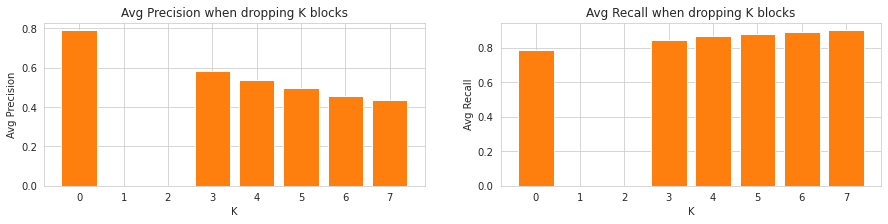

In [144]:
K = [0, 3, 4, 5, 6, 7]

plt.figure(figsize=[15, 3])
plt.subplot(1, 2, 1)
prec_per_dropblock = [recall_focused_numblockdropped_vs_prec[k][1.0] for k in K]
plt.title("Avg Precision when dropping K blocks")
plt.bar(K, prec_per_dropblock, color="C1")
plt.xlabel("K")
plt.ylabel("Avg Precision")


plt.subplot(1, 2, 2)
prec_per_dropblock = [recall_focused_numblockdropped_vs_rec[k][1.0] for k in K]
plt.title("Avg Recall when dropping K blocks")
plt.bar(K, prec_per_dropblock, color="C1")
plt.xlabel("K")
plt.ylabel("Avg Recall")

## Hypothesis:

by finetuning which config to use we might just encourage the network to always favor a single (or a few specific) classes

how to test: select a given class id and check the number of predicting the given class vs number of total predictions

In [37]:
best_config_id_per_class = train_class_vs_config_rec.argmax(-1)
preds = torch.load("logs/cache/val/16nCr7.pth")["preds"]
targets = torch.load("logs/cache/val/16nCr7.pth")["targets"]

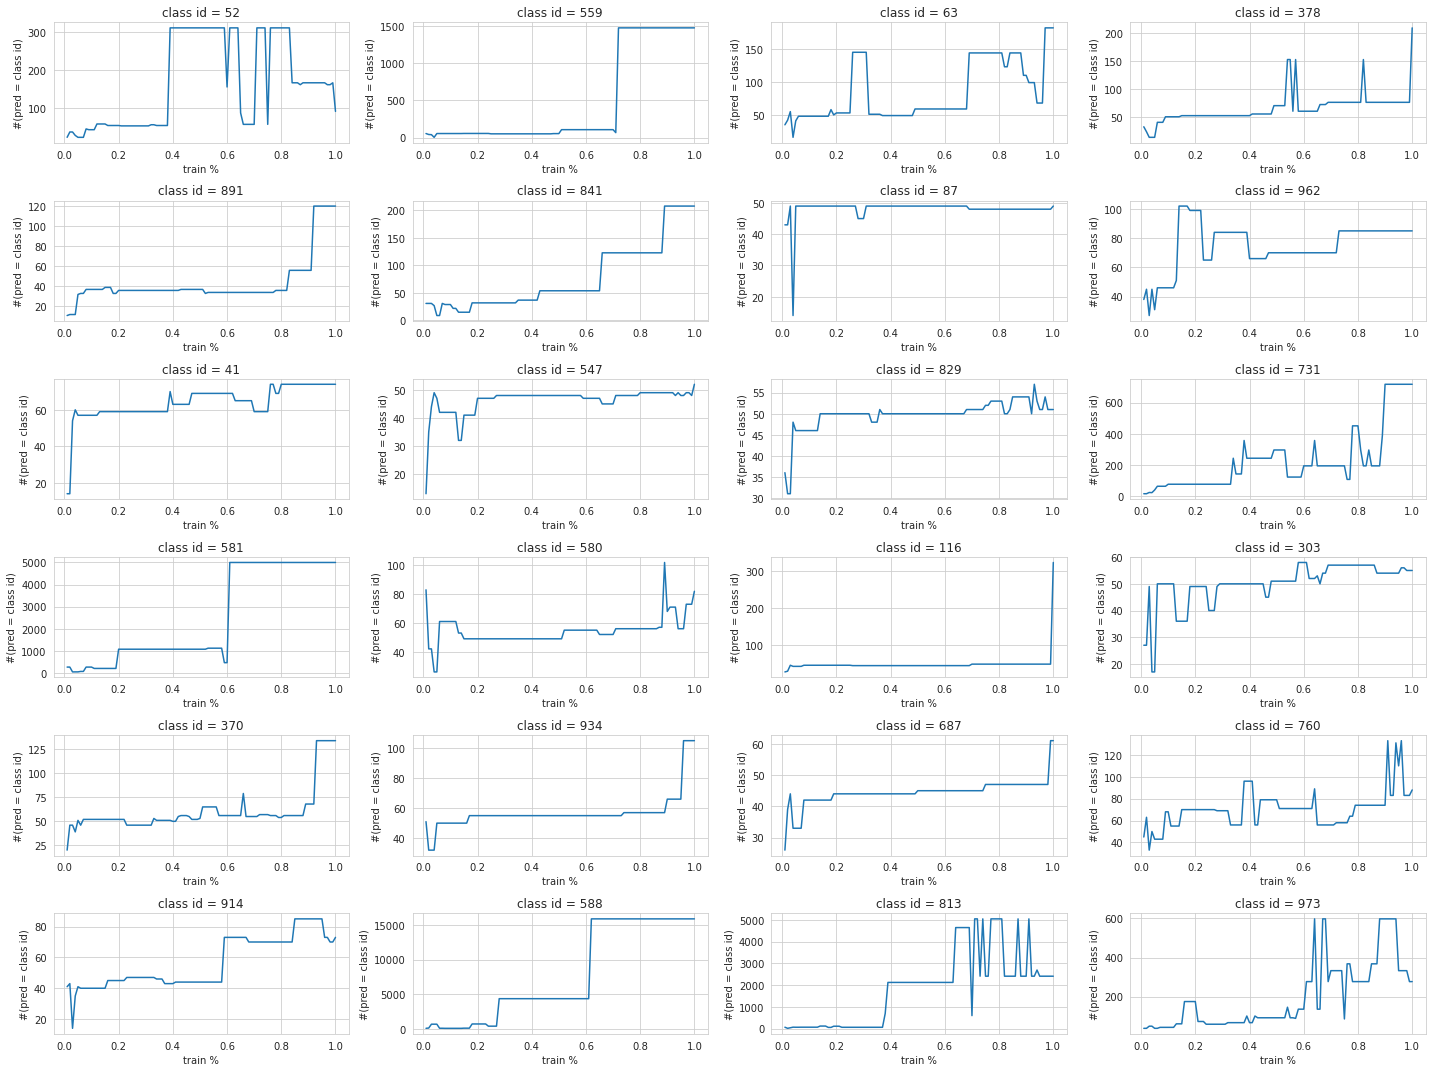

In [93]:
plt.figure(figsize=[20,15])
for i, class_id in enumerate(torch.randint(0, 1000, [24]), 1):
    ratio = (preds[best_config_id_per_class[:, class_id]]==class_id).sum(dim=1)
    target_line = (targets==class_id).sum()
    plt.subplot(6, 4, i)
    plt.title(f"class id = {class_id}")
    plt.ylabel("#(pred = class id)")
    plt.xlabel("train %")
    plt.plot(proportions, ratio.numpy())
    
plt.tight_layout()

## Time consume

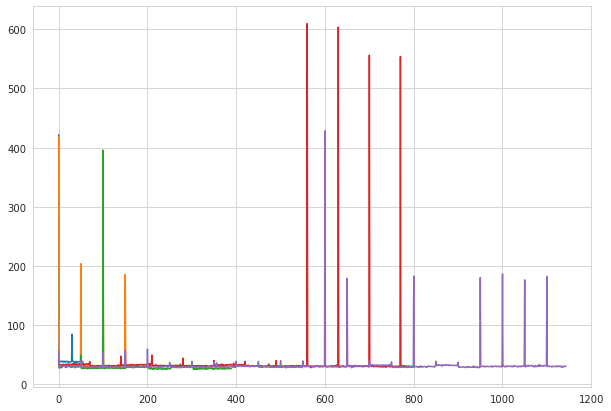

In [70]:
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
for k in [3, 4, 5, 6, 7]:
    fname = f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth"
    inference_times = torch.load(fname)["ineference_times"][::10]
    plt.plot(inference_times)
#     plt.ylim(35, 45)

In [75]:
k_inference_times = {}
for k in tqdm.notebook.tqdm([3, 4, 5, 6, 7]):
    fname = f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth"
    inference_times = torch.load(fname)["ineference_times"]
    k_inference_times[k] = inference_times

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 1.0, 'DROP-K inference time across different configs')

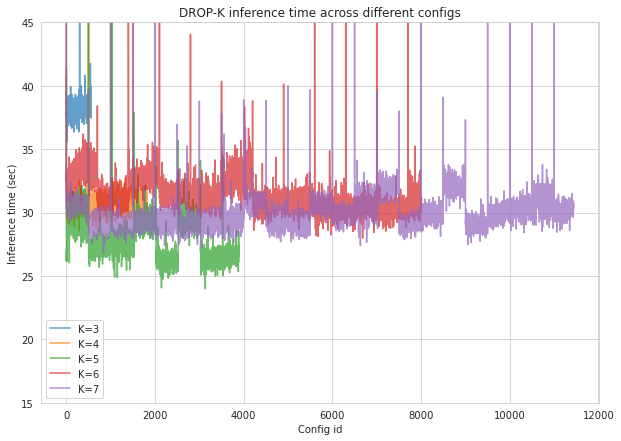

In [83]:
sns.set_style("whitegrid")
plt.figure(figsize=[10, 7])
for k in [3, 4, 5, 6, 7]:
    plt.plot(k_inference_times[k][::1], label=f"K={k}", alpha=0.7)
    plt.ylim(15, 45)
    
plt.legend()
plt.xlabel("Config id")
plt.ylabel("Inference time (sec)")
plt.title("DROP-K inference time across different configs")

In [63]:

torch.load(fname).keys()

dict_keys(['preds', 'targets', 'ineference_times'])

In [22]:
torch.clamp(torch.zeros(4), 1)

tensor([1., 1., 1., 1.])

In [28]:
num_classes = 3
def process_configs_trainval_debug(train_data, val_data, proportions, use_recall_for_selection=True):
    train_config_results = train_data
    train_num_configs = len(train_config_results["preds"])
    train_preds = train_config_results["preds"].cuda()
    train_targets = train_config_results["targets"].cuda()
    
    val_config_results = val_data
    val_num_configs = len(val_config_results["preds"])
    val_preds = val_config_results["preds"].cuda()
    val_targets = val_config_results["targets"].cuda()

    # assert train_num_configs == val_num_configs
    if train_num_configs != val_num_configs:
        print(f"WARNING (train_num_configs {train_num_configs} != val_num_configs {val_num_configs})")
    
#     train_size = int(train_preds.shape[1] * proportion)
#     train_preds = train_preds[:, :train_size]
#     train_targets = train_targets[:, :train_size]
    
    # TRAIN
    train_class_vs_config_prec = torch.zeros(len(proportions), num_classes, train_num_configs, dtype=float, device="cuda")
    train_class_vs_config_rec = torch.zeros(len(proportions), num_classes, train_num_configs, dtype=float, device="cuda")
    
    TP = train_preds == train_targets
    TP.cuda()
    for class_id in tqdm.notebook.tqdm(range(num_classes)):
        
        class_pred_mask = train_preds == class_id
        class_target_mask = train_targets == class_id
        class_TP = TP * class_target_mask
        prev_train_size = 0
        class_TP_sum = 0
        class_pred_sum = 0
        class_target_sum = 0
        for proportion_id, proportion in enumerate(proportions):
            train_size = int(train_preds.shape[1] * proportion)
            class_TP_sum += class_TP[:, prev_train_size:train_size].sum(dim=1)
            class_pred_sum += class_pred_mask[:, prev_train_size:train_size].sum(dim=1)
            class_target_sum += class_target_mask[:, prev_train_size:train_size].sum(dim=1)
            class_prec = class_TP_sum / torch.clamp(class_pred_sum, 1)
            class_rec = class_TP_sum / torch.clamp(class_target_sum, 1)
            train_class_vs_config_prec[proportion_id, class_id] = class_prec
            train_class_vs_config_rec[proportion_id, class_id] = class_rec
            
            prev_train_size = train_size
    
    return train_class_vs_config_prec, train_class_vs_config_rec
    
    val_precs = []
    val_recs = []
    for proportion_id, proportion in enumerate(proportions):
        if use_recall_for_selection:
            best_config_per_class = train_class_vs_config_rec[proportion_id].argmax(dim=1)
        else:
            best_config_per_class = train_class_vs_config_prec[proportion_id].argmax(dim=1)
        def class_rec(preds, targets, class_id):
            TP = preds == targets
            class_pred_mask = preds == class_id
            class_target_mask = targets == class_id
            prec = (TP * class_pred_mask).sum() / max(class_pred_mask.sum(), 1)
            rec = (TP * class_target_mask).sum() / max(class_target_mask.sum(), 1)
            return prec, rec

        val_prec = torch.zeros(num_classes, dtype=float, device="cuda")        
        val_rec = torch.zeros(num_classes, dtype=float, device="cuda")
        for class_id in range(num_classes):
            val_prec[class_id], val_rec[class_id] = class_rec(
                val_preds[best_config_per_class[class_id]],
                val_targets[best_config_per_class[class_id]],
                class_id
            )
        val_precs.append(val_prec)
        val_recs.append(val_rec)
    return val_precs, val_recs

In [50]:
train_data = {
    "preds": torch.tensor([
        [0, 0, 0, 1, 1], # max recall
        [0, 1, 1, 1, 1], # max precision
    ]),
    "targets": torch.tensor([
        [0, 2, 2, 0, 2],
        [0, 2, 2, 0, 2],
    ])
}

In [51]:
train_class_vs_config_prec, train_class_vs_config_rec = process_configs_trainval_debug(train_data, train_data, proportions=[0.2, 1.0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
train_class_vs_config_prec.shape

torch.Size([2, 3, 2])

In [53]:
train_class_vs_config_prec[0, 0]

tensor([1., 1.], device='cuda:0', dtype=torch.float64)

In [54]:
train_class_vs_config_rec[0, 0]

tensor([1., 1.], device='cuda:0', dtype=torch.float64)

In [55]:
train_class_vs_config_prec[1, 0]

tensor([0.3333, 1.0000], device='cuda:0', dtype=torch.float64)

In [56]:
train_class_vs_config_rec[1, 0]

tensor([0.5000, 0.5000], device='cuda:0', dtype=torch.float64)

## SANITY CHECK of `process_configs_trainval` WITHOUT VECTORIZATION

In [26]:
num_classes = 1000
def process_configs_trainval_SLOW(train_fname, val_fname, proportion):
    train_config_results = torch.load(train_fname)
    train_num_configs = len(train_config_results["preds"])
    train_preds = train_config_results["preds"].cuda()
    train_targets = train_config_results["targets"].cuda()
    
    val_config_results = torch.load(val_fname)
    val_num_configs = len(val_config_results["preds"])
    val_preds = val_config_results["preds"].cuda()
    val_targets = val_config_results["targets"].cuda()

    # assert train_num_configs == val_num_configs
    if train_num_configs != val_num_configs:
        print(f"WARNING (train_num_configs {train_num_configs} != val_num_configs {val_num_configs})")
    
    train_size = int(train_preds.shape[1] * proportion)
    train_preds = train_preds[:, :train_size]
    train_targets = train_targets[:, :train_size]
    
    # TRAIN
    train_class_vs_config_rec = torch.zeros(num_classes, train_num_configs, dtype=float, device="cuda")
    TP = train_preds == train_targets
    TP.cuda()
    for class_id in tqdm.notebook.tqdm(range(num_classes)):
        
        class_mask = train_targets == class_id
        class_TP = TP * class_mask
        class_TP_sum = class_TP.sum(dim=1)
        class_mask_sum = class_mask.sum(dim=1)
        class_rec = class_TP_sum / class_mask_sum
        train_class_vs_config_rec[class_id] = class_rec
    
    best_config_per_class = train_class_vs_config_rec.argmax(dim=1)
    def class_rec(preds, targets, class_id):
        TP = preds == targets
        class_mask = targets == class_id
        rec = (TP * class_mask).sum() / max(class_mask.sum(), 1)

        return rec



    val_rec = torch.zeros(num_classes, dtype=float, device="cuda")
    for class_id in range(num_classes):
        val_rec[class_id] = class_rec(
            val_preds[best_config_per_class[class_id]],
            val_targets[best_config_per_class[class_id]],
            class_id
        )
    return val_rec

numblockdropped_vs_rec_SLOW = {}
for k in [3]:
    proportion_vs_rec = {}
    for proportion in tqdm.notebook.tqdm(torch.linspace(0.01, 1.0, 20)):
        val_rec = process_configs_trainval_SLOW(
            f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth", 
            f"./logs/stats/16nCr{k}/all.pth",
            proportion=proportion)
        proportion_vs_rec[proportion.item()] = val_rec.mean().item()
        
    numblockdropped_vs_rec_SLOW[k] = proportion_vs_rec

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
numblockdropped_vs_prec

{0: {0.009999999776482582: 0.789164886713028,
  0.11999999731779099: 0.789164886713028,
  0.23000000417232513: 0.789164886713028,
  0.3400000035762787: 0.789164886713028,
  0.44999998807907104: 0.789164886713028,
  0.5600000023841858: 0.789164886713028,
  0.6700000166893005: 0.789164886713028,
  0.7799999713897705: 0.789164886713028,
  0.8899999856948853: 0.789164886713028,
  1.0: 0.789164886713028},
 3: {0.009999999776482582: 0.7960329492460005,
  0.11999999731779099: 0.7374878257941455,
  0.23000000417232513: 0.724699502248317,
  0.3400000035762787: 0.7015495128731709,
  0.44999998807907104: 0.6810055672626477,
  0.5600000023841858: 0.6635864381373394,
  0.6700000166893005: 0.6465787427781615,
  0.7799999713897705: 0.6275233175300527,
  0.8899999856948853: 0.6099738450819859,
  1.0: 0.582155439481372}}

In [28]:
numblockdropped_vs_rec_SLOW

{3: {0.009999999776482582: 0.5812599994316697,
  0.06210526078939438: 0.7087399987652898,
  0.11421052366495132: 0.7676999979317188,
  0.16631579399108887: 0.780539997547865,
  0.2184210568666458: 0.7944199974536896,
  0.27052628993988037: 0.8013199979364872,
  0.3226315677165985: 0.8053599981069565,
  0.37473684549331665: 0.811359998434782,
  0.4268420934677124: 0.8144399982988835,
  0.47894734144210815: 0.8206599980592728,
  0.5310525894165039: 0.8241999978721142,
  0.5831578969955444: 0.8258799978494644,
  0.6352631449699402: 0.8291999981403351,
  0.6873683929443359: 0.8325599985420704,
  0.7394737005233765: 0.835079998254776,
  0.7915789484977722: 0.8368599973618984,
  0.843684196472168: 0.8384399972558022,
  0.8957895040512085: 0.8427199976742268,
  0.9478947520256042: 0.8437399978339672,
  1.0: 0.8468599977195264}}

## Yay!

## SANITY CHECK of `process_configs_trainval` WITHOUT VECTORIZATION

In [26]:
num_classes = 1000
def process_configs_trainval_SLOW(train_fname, val_fname, proportion):
    train_config_results = torch.load(train_fname)
    train_num_configs = len(train_config_results["preds"])
    train_preds = train_config_results["preds"].cuda()
    train_targets = train_config_results["targets"].cuda()
    
    val_config_results = torch.load(val_fname)
    val_num_configs = len(val_config_results["preds"])
    val_preds = val_config_results["preds"].cuda()
    val_targets = val_config_results["targets"].cuda()

    # assert train_num_configs == val_num_configs
    if train_num_configs != val_num_configs:
        print(f"WARNING (train_num_configs {train_num_configs} != val_num_configs {val_num_configs})")
    
    train_size = int(train_preds.shape[1] * proportion)
    train_preds = train_preds[:, :train_size]
    train_targets = train_targets[:, :train_size]
    
    # TRAIN
    train_class_vs_config_rec = torch.zeros(num_classes, train_num_configs, dtype=float, device="cuda")
    TP = train_preds == train_targets
    TP.cuda()
    for class_id in tqdm.notebook.tqdm(range(num_classes)):
        
        class_mask = train_targets == class_id
        class_TP = TP * class_mask
        class_TP_sum = class_TP.sum(dim=1)
        class_mask_sum = class_mask.sum(dim=1)
        class_rec = class_TP_sum / class_mask_sum
        train_class_vs_config_rec[class_id] = class_rec
    
    best_config_per_class = train_class_vs_config_rec.argmax(dim=1)
    def class_rec(preds, targets, class_id):
        TP = preds == targets
        class_mask = targets == class_id
        rec = (TP * class_mask).sum() / max(class_mask.sum(), 1)

        return rec



    val_rec = torch.zeros(num_classes, dtype=float, device="cuda")
    for class_id in range(num_classes):
        val_rec[class_id] = class_rec(
            val_preds[best_config_per_class[class_id]],
            val_targets[best_config_per_class[class_id]],
            class_id
        )
    return val_rec

numblockdropped_vs_rec_SLOW = {}
for k in [3]:
    proportion_vs_rec = {}
    for proportion in tqdm.notebook.tqdm(torch.linspace(0.01, 1.0, 20)):
        val_rec = process_configs_trainval_SLOW(
            f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth", 
            f"./logs/stats/16nCr{k}/all.pth",
            proportion=proportion)
        proportion_vs_rec[proportion.item()] = val_rec.mean().item()
        
    numblockdropped_vs_rec_SLOW[k] = proportion_vs_rec

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
numblockdropped_vs_prec

{0: {0.009999999776482582: 0.789164886713028,
  0.11999999731779099: 0.789164886713028,
  0.23000000417232513: 0.789164886713028,
  0.3400000035762787: 0.789164886713028,
  0.44999998807907104: 0.789164886713028,
  0.5600000023841858: 0.789164886713028,
  0.6700000166893005: 0.789164886713028,
  0.7799999713897705: 0.789164886713028,
  0.8899999856948853: 0.789164886713028,
  1.0: 0.789164886713028},
 3: {0.009999999776482582: 0.7960329492460005,
  0.11999999731779099: 0.7374878257941455,
  0.23000000417232513: 0.724699502248317,
  0.3400000035762787: 0.7015495128731709,
  0.44999998807907104: 0.6810055672626477,
  0.5600000023841858: 0.6635864381373394,
  0.6700000166893005: 0.6465787427781615,
  0.7799999713897705: 0.6275233175300527,
  0.8899999856948853: 0.6099738450819859,
  1.0: 0.582155439481372}}

In [28]:
numblockdropped_vs_rec_SLOW

{3: {0.009999999776482582: 0.5812599994316697,
  0.06210526078939438: 0.7087399987652898,
  0.11421052366495132: 0.7676999979317188,
  0.16631579399108887: 0.780539997547865,
  0.2184210568666458: 0.7944199974536896,
  0.27052628993988037: 0.8013199979364872,
  0.3226315677165985: 0.8053599981069565,
  0.37473684549331665: 0.811359998434782,
  0.4268420934677124: 0.8144399982988835,
  0.47894734144210815: 0.8206599980592728,
  0.5310525894165039: 0.8241999978721142,
  0.5831578969955444: 0.8258799978494644,
  0.6352631449699402: 0.8291999981403351,
  0.6873683929443359: 0.8325599985420704,
  0.7394737005233765: 0.835079998254776,
  0.7915789484977722: 0.8368599973618984,
  0.843684196472168: 0.8384399972558022,
  0.8957895040512085: 0.8427199976742268,
  0.9478947520256042: 0.8437399978339672,
  1.0: 0.8468599977195264}}

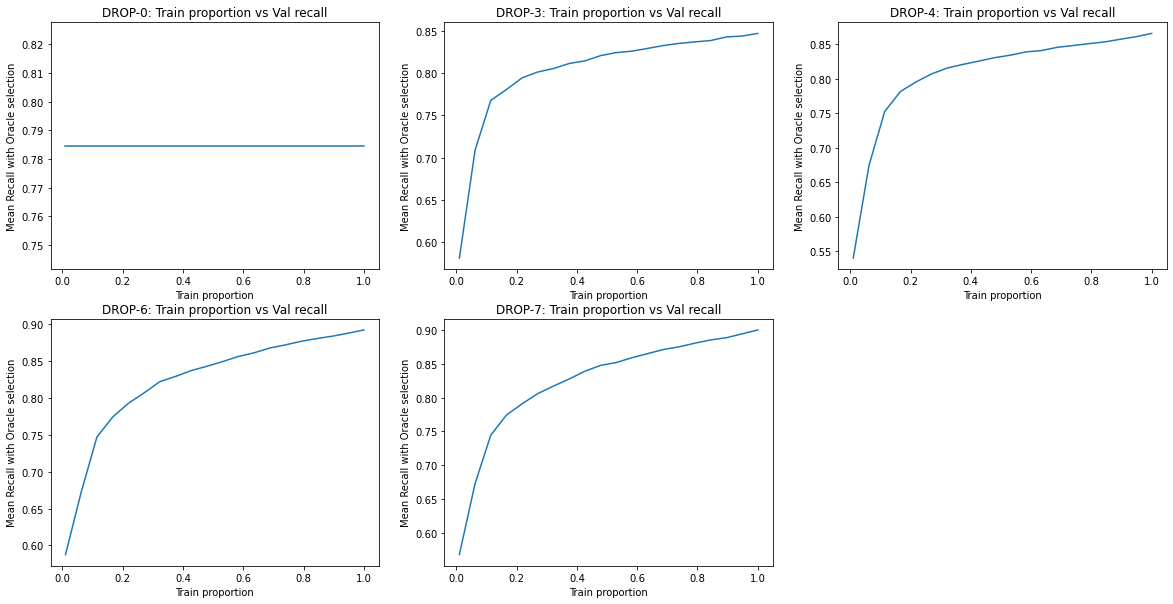

In [39]:
plt.figure(figsize=[20, 10])
for i, k in enumerate([0, 3, 4, 6, 7], start=1):
    proportion_vs_acc = numblockdropped_vs_rec[k]
    plt.subplot(2, 3, i)
    plt.plot(proportion_vs_acc.keys(), proportion_vs_acc.values())
    plt.title(f"DROP-{k}: Train proportion vs Val recall")
    plt.xlabel("Train proportion")
    plt.ylabel("Mean Recall with Oracle selection")
plt.show()

## Find clustered labels correspondance

When multiple class chooses the same configuration find which classes are those and if there is any semantically meaninngful connection between

In [205]:
import json
imagenet_id_to_str = json.load(open("imagenet_class_index.json"))
imagenet_id_to_str = {int(k):v[1] for k, v in imagenet_id_to_str.items()}

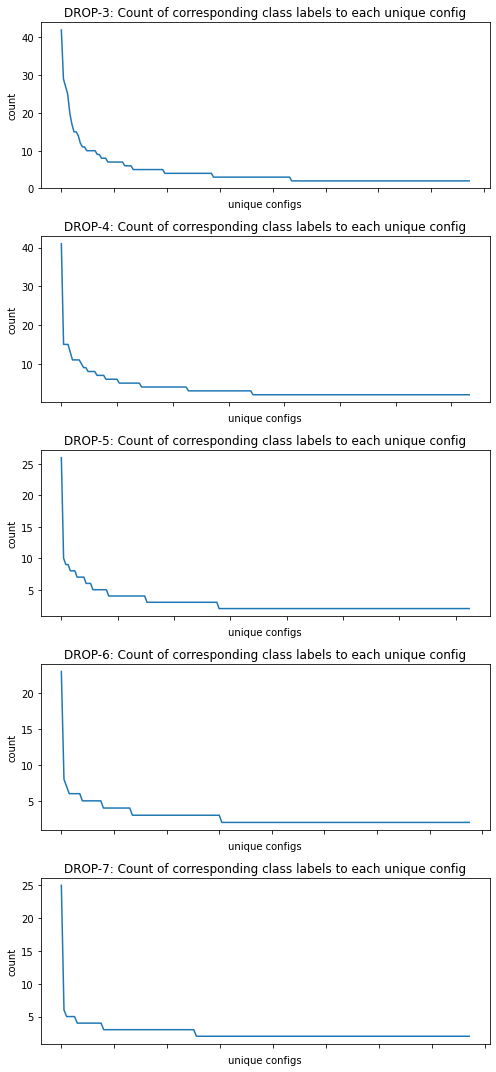

In [262]:
plt.figure(figsize=[7, 15])
for i, k in enumerate([3, 4, 5, 6, 7], start=1):    
#     class_vs_config_accuracies = process_configs(f"logs/stats/16nCr{k}/all.pth")
    class_vs_config_accuracies = torch.load(f"class_vs_config_accuracies_16nCr{k}.pth")
    num_configs = class_vs_config_accuracies.shape[1]

    def unique(x, dim=-1):
        unique, inverse = torch.unique(x, return_inverse=True, dim=dim)
        perm = torch.arange(inverse.size(dim), dtype=inverse.dtype, device=inverse.device)
        inverse, perm = inverse.flip([dim]), perm.flip([dim])
        return unique, inverse.new_empty(unique.size(dim)).scatter_(dim, inverse, perm)
    best_config_per_class = class_vs_config_accuracies.argmax(dim=1)
    unique_val, unique_ind = unique(best_config_per_class)
    _, unique_count = torch.unique(class_vs_config_accuracies.argmax(dim=1), return_counts=True)


    # Find configs that have more than 1 occurence:
    config_vs_best_classids = {}
    config_mask = unique_count > 1

    for config_id in unique_val[config_mask]:
        best_classids = torch.nonzero(best_config_per_class == config_id).flatten().tolist()
        config_vs_best_classids[config_id.item()] = best_classids

    config_vs_best_classtxt = {}
    for config_id, best_classids in config_vs_best_classids.items():
        class_txts = [imagenet_id_to_str[cid] for cid in best_classids]
        config_vs_best_classtxt[config_id] = class_txts

    config_vs_best_classtxt = {
        k: v
        for k, v in sorted(config_vs_best_classtxt.items(), key=lambda item: -len(item[1]))
    }
    
    plt.subplot(5, 1, i)
    plt.plot(range(len(config_vs_best_classtxt)), [len(v) for v in config_vs_best_classtxt.values()], )
    plt.title(f"DROP-{k}: Count of corresponding class labels to each unique config")
    plt.ylabel("count")
    plt.xlabel("unique configs")
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    plt.tight_layout()

In [242]:
for k, v in config_vs_best_classtxt.items():
    print(f"{k},{','.join(v)}")

8,junco,great_grey_owl,scorpion,tarantula,echidna,wallaby,European_gallinule,papillon,Samoyed,dhole,African_hunting_dog,Angora,Arabian_camel,armadillo,three-toed_sloth,proboscis_monkey,lesser_panda,corkscrew,fireboat,maypole,web_site,buckeye,earthstar
2928,black_stork,fly,ox,giant_panda,minivan,plastic_bag,whiskey_jug,lakeside
924,tench,jacamar,slug,Norwich_terrier,Welsh_springer_spaniel,carpenter's_kit,yawl
612,Italian_greyhound,Great_Pyrenees,neck_brace,teddy,pineapple,geyser
750,frilled_lizard,curly-coated_retriever,Sussex_spaniel,EntleBucher,kit_fox,sloth_bear
2448,pug,sulphur_butterfly,anemone_fish,magnetic_compass,volleyball,bagel
2925,kite,hornbill,accordion,bulletproof_vest,shield,book_jacket
4136,white_stork,Mexican_hairless,bow,grocery_store,Loafer,tricycle
2,spoonbill,ruddy_turnstone,Leonberg,pillow,tank
10,vulture,hummingbird,clumber,Rottweiler,lion
18,American_egret,redshank,Bernese_mountain_dog,hamster,daisy
738,Japanese_spaniel,Walker_hound,lotion,milk_can,overskirt
816,

## Old experiments

## Choose 4

In [52]:
# def process_configs_slow(fname):
    
#     def process_config(preds, targets):
#         class_accuracies = torch.zeros(
#             num_classes, dtype=float
#         )
#         TP = preds == targets
#         for class_id in range(num_classes):
#             class_mask = targets == class_id
#             class_accuracy = (TP[class_mask]).sum() / max(class_mask.sum(), 1)
#             class_accuracies[class_id] = class_accuracy

#         return class_accuracies
    
#     all_config_results = torch.load(fname)
#     num_configs = len(all_config_results["preds"])
#     preds = all_config_results["preds"].cuda()
#     targets = all_config_results["targets"].cuda()
#     class_vs_config_accuracies = torch.zeros(num_classes, num_configs, dtype=float, device="cuda")
#     # WITHOUT VECTORIZATION THIS IS SLOWER:
#     for config_id in tqdm.notebook.tqdm(range(num_configs)):
#         try:
#             p, t = preds[config_id], targets[config_id]
#             class_accuracies = process_config(p, t)
#             class_vs_config_accuracies[:, config_id] = class_accuracies
#         except FileNotFoundError:
#             print("missing", fname)
#             pass
#     return class_vs_config_accuracies.cpu()
# class_vs_config_accuracies_slow = process_configs_slow("./logs/stats/16nCr3/all.pth")


num_classes = 1000
def process_configs(fname):
    all_config_results = torch.load(fname)
    num_configs = len(all_config_results["preds"])
    num_samples = len(all_config_results["preds"][0])
    preds = all_config_results["preds"].cuda()
    targets = all_config_results["targets"].cuda()
    class_vs_config_prec = torch.zeros(num_classes, num_configs, dtype=float, device="cuda")
    class_vs_config_rec = torch.zeros(num_classes, num_configs, dtype=float, device="cuda")



    TP = preds == targets
    FP = preds != targets

    TP.cuda()
    for class_id in tqdm.notebook.tqdm(range(num_classes)):
        class_mask = targets == class_id
        class_TP = (TP * class_mask).sum(dim=1)
        class_FP = (FP * class_mask).sum(dim=1)
        class_num_samples = class_mask.sum(dim=1)
#         class_TN = ((preds * ~class_mask) != (targets * ~class_mask)).sum(dim=1)
        class_prec = class_TP / class_num_samples
        class_rec = class_TP / (class_TP + class_FP)
        class_vs_config_prec[class_id] = class_prec
        class_vs_config_rec[class_id] = class_rec
    
    class_vs_config_stats = {
        "prec": class_vs_config_prec.cpu(),
        "rec": class_vs_config_rec.cpu()
    }
    return class_vs_config_stats

    
# class_vs_config_accuracies = process_configs("./logs/stats/16nCr3/all.pth")
# num_configs = class_vs_config_accuracies.shape[1]

In [53]:
for i in [3]:
    print(f"{i}: ", file_count(f"./logs/cache/train/0.1/cache/train/16nCr{i}/"), "out of", math.comb(16, i))
    class_vs_config_stats = process_configs(f"./logs/cache/train/0.1/cache/train/16nCr{i}/all.pth")
    torch.save(class_vs_config_stats, f"class_vs_config_accuracies_16nCr{i}.pth")

3:  560 out of 560


  0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
class_vs_config_stats["prec"].max(dim=1)

torch.return_types.max(
values=tensor([0.9760, 1.0000, 0.9615, 0.9600, 0.9847, 0.9394, 0.9597, 0.9799, 0.8837,
        1.0000, 1.0000, 0.9921, 0.9912, 1.0000, 0.9933, 0.9921, 1.0000, 0.9928,
        1.0000, 0.9918, 0.9907, 0.9844, 1.0000, 0.9769, 0.9915, 0.9805, 0.8468,
        0.9786, 0.9441, 1.0000, 0.9730, 0.9919, 0.9147, 0.9638, 0.9474, 0.9519,
        0.9440, 0.9520, 0.9516, 0.9750, 0.9786, 0.9440, 0.9520, 0.9402, 0.9728,
        0.9680, 0.9115, 0.9764, 1.0000, 0.9435, 0.9778, 1.0000, 0.9173, 0.9099,
        0.9450, 0.9259, 0.9790, 0.9778, 0.9612, 0.9667, 0.9173, 0.9470, 0.8889,
        0.9677, 0.9542, 0.9219, 0.7704, 0.9771, 0.9452, 0.9784, 0.9918, 1.0000,
        1.0000, 0.9291, 0.7377, 0.9839, 0.9664, 0.9725, 0.9767, 0.9835, 0.9855,
        0.9907, 0.8462, 0.9831, 1.0000, 0.9844, 0.8772, 0.9917, 0.9924, 1.0000,
        1.0000, 0.9851, 0.9931, 0.9921, 1.0000, 1.0000, 0.9857, 0.9920, 1.0000,
        1.0000, 1.0000, 0.8905, 1.0000, 0.9712, 1.0000, 1.0000, 0.9573, 1.0000,
        0

Text(0, 0.5, 'num of best performing classes')

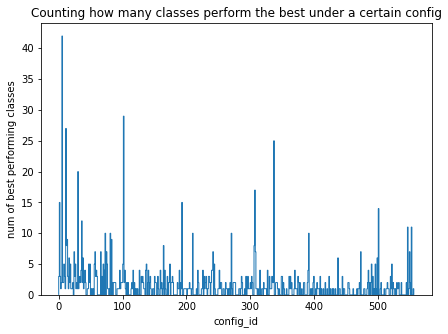

In [79]:
plt.figure(figsize=[7, 5])
plt.hist(class_vs_config_accuracies.argmax(dim=1).numpy(), num_configs, histtype="step")
plt.title("Counting how many classes perform the best under a certain config")
plt.xlabel("config_id")
plt.ylabel("num of best performing classes")

Text(0, 0.5, 'num of worst performing classes')

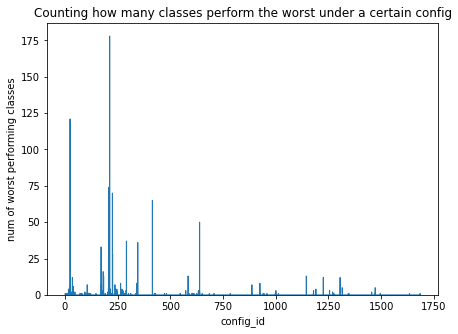

In [109]:
plt.figure(figsize=[7, 5])
plt.hist(class_vs_config_accuracies.argmin(dim=1).numpy(), num_configs, histtype="step")
plt.title("Counting how many classes perform the worst under a certain config")
plt.xlabel("config_id")
plt.ylabel("num of worst performing classes")

## Choose 7

In [152]:
class_vs_config_accuracies = process_configs("logs/stats/16nCr7/all.pth")
num_configs = class_vs_config_accuracies.shape[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [153]:
class_vs_config_accuracies.max(dim=1).values.mean()

tensor(0.9404, dtype=torch.float64)

Text(0, 0.5, 'num of best performing classes')

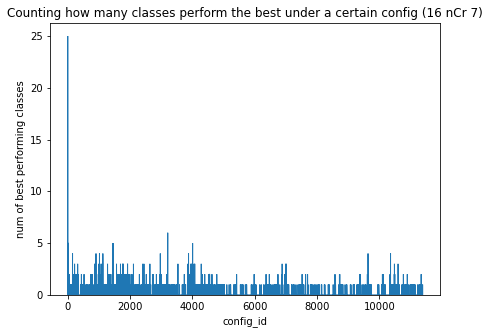

In [157]:
plt.figure(figsize=[7, 5])
plt.hist(class_vs_config_accuracies.argmax(dim=1).numpy(), num_configs, histtype="step")
plt.title("Counting how many classes perform the best under a certain config (16 nCr 7)")
plt.xlabel("config_id")
plt.ylabel("num of best performing classes")

Text(0, 0.5, 'num of worst performing classes')

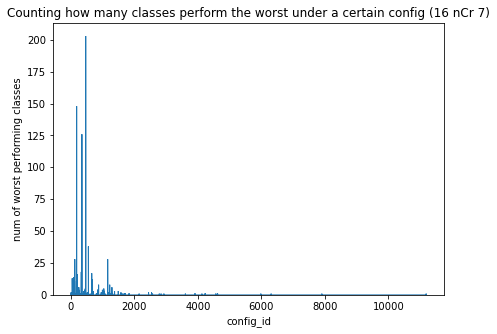

In [155]:
plt.figure(figsize=[7, 5])
plt.hist(class_vs_config_accuracies.argmin(dim=1).numpy(), num_configs, histtype="step")
plt.title("Counting how many classes perform the worst under a certain config (16 nCr 7)")
plt.xlabel("config_id")
plt.ylabel("num of worst performing classes")

## Find optimal architecture on Val1 and test on Val2

In [84]:
x = torch.load(f"./logs/stats/16nCr3/all.pth")
preds = x["preds"]
targets = x["targets"]

In [107]:
accuracy(preds[0], targets[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.5600, 0.7200, 0.7200, 0.5400, 0.8200, 0.7400, 0.4400, 0.4000, 0.6400,
        0.7600, 0.4400, 0.8600, 0.3800, 0.5600, 0.6600, 0.3600, 0.5000, 0.5400,
        0.6600, 0.5800, 0.6000, 0.5800, 0.7800, 0.6800, 0.5600, 0.6400, 0.5600,
        0.4400, 0.4200, 0.7200, 0.6600, 0.7000, 0.1600, 0.5200, 0.5400, 0.3400,
        0.5200, 0.5200, 0.4600, 0.3400, 0.4400, 0.6800, 0.4800, 0.1600, 0.4400,
        0.6800, 0.5200, 0.4800, 0.6600, 0.4200, 0.3400, 0.5200, 0.6400, 0.7000,
        0.4600, 0.8000, 0.7600, 0.7600, 0.5400, 0.5000, 0.5200, 0.5800, 0.3000,
        0.7200, 0.4200, 0.5800, 0.4600, 0.3800, 0.3800, 0.6000, 0.8400, 0.8600,
        0.6400, 0.3000, 0.3800, 0.7800, 0.6800, 0.5400, 0.7600, 0.5800, 0.7000,
        0.5200, 0.3600, 0.7200, 0.6800, 0.6200, 0.5600, 0.8000, 0.7400, 0.8000,
        0.7200, 0.5200, 0.7800, 0.8200, 0.6800, 0.3400, 0.9000, 0.7800, 0.8800,
        0.7600, 0.7800, 0.2400, 0.8200, 0.5600, 0.3600, 0.2800, 0.3600, 0.8600,
        0.6000, 0.8000, 0.7000, 0.8200, 

In [79]:
num_classes = 1000
def process_configs_trainval(train_fname, val_fname, proportion):
    train_config_results = torch.load(train_fname)
    train_num_configs = len(train_config_results["preds"])
    train_preds = train_config_results["preds"].cuda()
    train_targets = train_config_results["targets"].cuda()
    
    val_config_results = torch.load(val_fname)
    val_num_configs = len(val_config_results["preds"])
    val_preds = val_config_results["preds"].cuda()
    val_targets = val_config_results["targets"].cuda()

    assert train_num_configs == val_num_configs
    
    train_size = int(train_preds.shape[1] * proportion)
    train_preds = train_preds[:, :train_size]
    train_targets = train_targets[:, :train_size]
    
    # TRAIN
    train_class_vs_config_rec = torch.zeros(num_classes, train_num_configs, dtype=float, device="cuda")
    TP = train_preds == train_targets
    TP.cuda()
    for class_id in tqdm.notebook.tqdm(range(num_classes)):
        class_mask = train_targets == class_id
        class_rec = (TP * class_mask).sum(dim=1) / class_mask.sum(dim=1)
        train_class_vs_config_rec[class_id] = class_rec
    
    best_config_per_class = train_class_vs_config_rec.argmax(dim=1)
    
    def class_rec(preds, targets, class_id):
        TP = preds == targets
        class_mask = targets == class_id
        rec = (TP * class_mask).sum() / max(class_mask.sum(), 1)

        return rec

    
    
    val_rec = torch.zeros(num_classes, dtype=float, device="cuda")
    for class_id in range(num_classes):
        val_rec[class_id] = class_rec(
            val_preds[best_config_per_class[class_id]],
            val_targets[best_config_per_class[class_id]],
            class_id
        )
    return val_rec

In [84]:
numblockdropped_vs_rec = {}
for k in [3, 4]:
    proportion_vs_rec = {}
    for proportion in tqdm.notebook.tqdm(torch.linspace(0.05, 0.9, 20)):
        val_rec = process_configs_trainval(
            f"./logs/cache/train/0.1/cache/train/16nCr{k}/all.pth", 
            f"./logs/stats/16nCr{k}/all.pth",
            proportion=proportion)
        proportion_vs_rec[proportion.item()] = val_rec.mean().item()
    numblockdropped_vs_rec[k] = proportion_vs_rec

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
torch.save(numblockdropped_vs_rec, "numblockdropped_vs_rec_3-4_0.05-0.9_step20.pth")

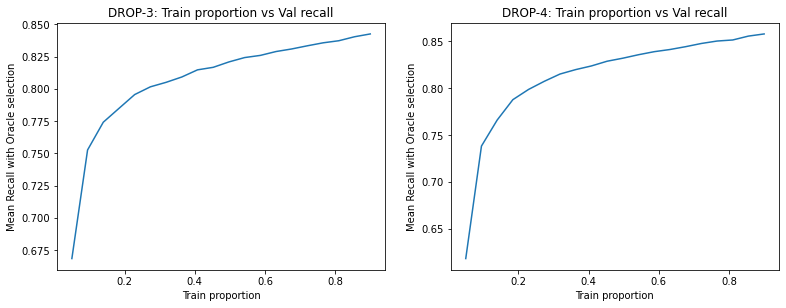

In [89]:
plt.figure(figsize=[20, 10])
for i, k in enumerate([3, 4], start=1):
    proportion_vs_acc = numblockdropped_vs_rec[k]
    plt.subplot(2, 3, i)
    plt.plot(proportion_vs_acc.keys(), proportion_vs_acc.values())
    plt.title(f"DROP-{k}: Train proportion vs Val recall")
    plt.xlabel("Train proportion")
    plt.ylabel("Mean Recall with Oracle selection")
plt.show()

## Find clustered labels correspondance

When multiple class chooses the same configuration find which classes are those and if there is any semantically meaninngful connection between

In [205]:
import json
imagenet_id_to_str = json.load(open("imagenet_class_index.json"))
imagenet_id_to_str = {int(k):v[1] for k, v in imagenet_id_to_str.items()}

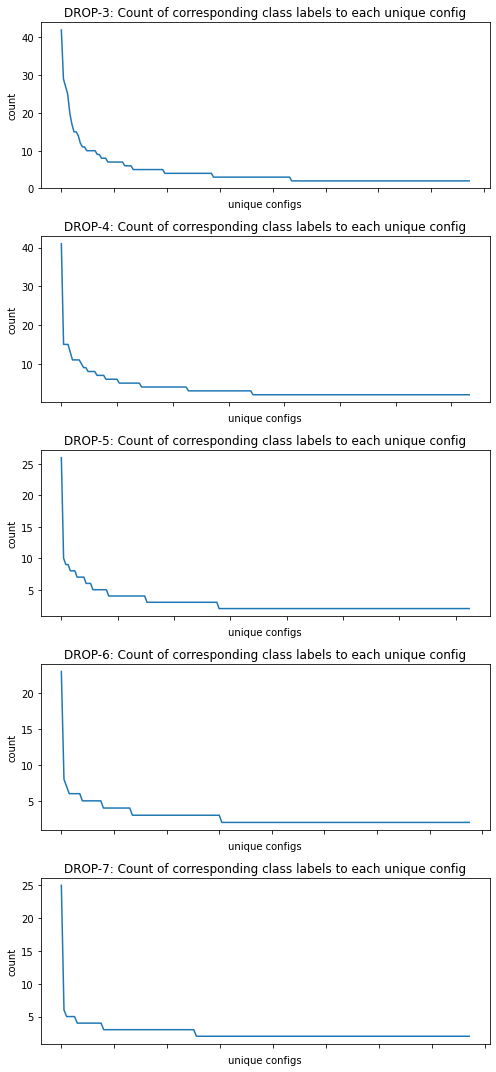

In [262]:
plt.figure(figsize=[7, 15])
for i, k in enumerate([3, 4, 5, 6, 7], start=1):    
#     class_vs_config_accuracies = process_configs(f"logs/stats/16nCr{k}/all.pth")
    class_vs_config_accuracies = torch.load(f"class_vs_config_accuracies_16nCr{k}.pth")
    num_configs = class_vs_config_accuracies.shape[1]

    def unique(x, dim=-1):
        unique, inverse = torch.unique(x, return_inverse=True, dim=dim)
        perm = torch.arange(inverse.size(dim), dtype=inverse.dtype, device=inverse.device)
        inverse, perm = inverse.flip([dim]), perm.flip([dim])
        return unique, inverse.new_empty(unique.size(dim)).scatter_(dim, inverse, perm)
    best_config_per_class = class_vs_config_accuracies.argmax(dim=1)
    unique_val, unique_ind = unique(best_config_per_class)
    _, unique_count = torch.unique(class_vs_config_accuracies.argmax(dim=1), return_counts=True)


    # Find configs that have more than 1 occurence:
    config_vs_best_classids = {}
    config_mask = unique_count > 1

    for config_id in unique_val[config_mask]:
        best_classids = torch.nonzero(best_config_per_class == config_id).flatten().tolist()
        config_vs_best_classids[config_id.item()] = best_classids

    config_vs_best_classtxt = {}
    for config_id, best_classids in config_vs_best_classids.items():
        class_txts = [imagenet_id_to_str[cid] for cid in best_classids]
        config_vs_best_classtxt[config_id] = class_txts

    config_vs_best_classtxt = {
        k: v
        for k, v in sorted(config_vs_best_classtxt.items(), key=lambda item: -len(item[1]))
    }
    
    plt.subplot(5, 1, i)
    plt.plot(range(len(config_vs_best_classtxt)), [len(v) for v in config_vs_best_classtxt.values()], )
    plt.title(f"DROP-{k}: Count of corresponding class labels to each unique config")
    plt.ylabel("count")
    plt.xlabel("unique configs")
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    plt.tight_layout()

In [242]:
for k, v in config_vs_best_classtxt.items():
    print(f"{k},{','.join(v)}")

8,junco,great_grey_owl,scorpion,tarantula,echidna,wallaby,European_gallinule,papillon,Samoyed,dhole,African_hunting_dog,Angora,Arabian_camel,armadillo,three-toed_sloth,proboscis_monkey,lesser_panda,corkscrew,fireboat,maypole,web_site,buckeye,earthstar
2928,black_stork,fly,ox,giant_panda,minivan,plastic_bag,whiskey_jug,lakeside
924,tench,jacamar,slug,Norwich_terrier,Welsh_springer_spaniel,carpenter's_kit,yawl
612,Italian_greyhound,Great_Pyrenees,neck_brace,teddy,pineapple,geyser
750,frilled_lizard,curly-coated_retriever,Sussex_spaniel,EntleBucher,kit_fox,sloth_bear
2448,pug,sulphur_butterfly,anemone_fish,magnetic_compass,volleyball,bagel
2925,kite,hornbill,accordion,bulletproof_vest,shield,book_jacket
4136,white_stork,Mexican_hairless,bow,grocery_store,Loafer,tricycle
2,spoonbill,ruddy_turnstone,Leonberg,pillow,tank
10,vulture,hummingbird,clumber,Rottweiler,lion
18,American_egret,redshank,Bernese_mountain_dog,hamster,daisy
738,Japanese_spaniel,Walker_hound,lotion,milk_can,overskirt
816,